# Benchmark Analysis

This notebook loads and analyzes benchmark results from the CSV exported by `export_bench_to_csv.py`.


In [21]:
# %pip install -r requirements.txt

In [22]:
# Import packages
# Cell 1: Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Packages loaded successfully")


✓ Packages loaded successfully


In [23]:
# Chart Configuration
# ============================================================================

# Limit time series charts to the last N measurements (per operation/size). Set to None to show all.
LAST_N = 20

# Y-axis scale for ALL charts (bar charts and time series): 'log' or 'linear'
Y_SCALE = 'log'

# Y-axis minimum for comparison bar charts (Cells 6 & 7 only)
# - "auto": Let matplotlib auto-fit (default behavior)
# - 0 or 0.0: Y-axis starts at 0 (shows absolute differences)
# - 1 or 1.0: Y-axis starts at minimum value (emphasizes relative differences)
# - Values between 0-1: Interpolate (e.g., 0.5 = halfway between 0 and min value)
# Y_MIN = 0
Y_MIN = 0.5

print(f"Timeseries limit: {LAST_N if LAST_N is not None else 'ALL'}")
print(f"Y-axis scale (all charts): {Y_SCALE}")
print(f"Y-axis min (bar charts only): {Y_MIN}")


Timeseries limit: 20
Y-axis scale (all charts): log
Y-axis min (bar charts only): 0.5


In [24]:
# Cell 2: Set variables and run export script

import subprocess
import sys

# CSV file location (relative to notebook or absolute path)
CSV_FILE = "benchmark_results.csv"

# Export script location
EXPORT_SCRIPT = "export_bench_to_csv.py"

# Tag for this run (change as needed)
RUN_TAG = "RADIX 2"

# Source directory: "new" or "base"
SOURCE = "new"

# Benchmark filter (optional, leave empty for all)
BENCH_FILTER = ""

print("=" * 80)
print("Running export script to update CSV with latest benchmark results...")
print("=" * 80)

# Build command
cmd = [sys.executable, EXPORT_SCRIPT, "--tag", RUN_TAG, "--source", SOURCE]
if BENCH_FILTER:
    cmd.extend(["--bench", BENCH_FILTER])

# Run export script
result = subprocess.run(cmd, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)

print("\n" + "=" * 80)

# Convert to Path object
csv_path = Path(CSV_FILE)
if not csv_path.is_absolute():
    csv_path = Path.cwd() / CSV_FILE

print(f"CSV file: {csv_path}")
print(f"File exists: {csv_path.exists()}")

if csv_path.exists():
    print(f"File size: {csv_path.stat().st_size:,} bytes")


Running export script to update CSV with latest benchmark results...
Checking for existing results in /Users/jordan/code/econic/massive-graph/bench_analysis/benchmark_results.csv...
Found 503 existing benchmark records
Parsing benchmark results from /Users/jordan/code/econic/massive-graph/target/criterion (source: new)...
Tag: 'RADIX 2'
Found 8 benchmark results
No new results found (skipped 8 duplicates)


CSV file: /Users/jordan/code/econic/massive-graph/bench_analysis/benchmark_results.csv
File exists: True
File size: 87,872 bytes


In [25]:
# Cell 3: Load CSV into DataFrame

# Read CSV
df = pd.read_csv(csv_path)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert size to numeric where possible
df['size_numeric'] = pd.to_numeric(df['size'], errors='coerce')

# Sort by timestamp
df = df.sort_values('timestamp')

# Display summary
print(f"✓ Loaded {len(df)} benchmark results")
print(f"\nDate range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nUnique benchmarks: {df['benchmark'].nunique()}")
print(f"Unique operations: {df['operation'].nunique()}")
print(f"Unique tags: {df['tag'].nunique()}")

# Display first few rows
print("\nFirst 5 records:")
display(df.head())

# Display basic statistics
print("\nBasic statistics (median_ns):")
display(df[['median_ns']].describe())


✓ Loaded 503 benchmark results

Date range: 2025-10-17 15:51:59.487430 to 2025-11-02 17:07:54.420060

Unique benchmarks: 2
Unique operations: 17
Unique tags: 40

First 5 records:


run_id        benchmark            test_name         operation  \
5   20251017_155159  compare_get_16b       hashmap_get/64       hashmap_get   
21  20251017_155209  compare_get_16b       dashmap_get/64       dashmap_get   
37  20251017_155219  compare_get_16b         btree_get/64         btree_get   
33  20251017_155228  compare_get_16b  optidx_radix_get/64  optidx_radix_get   
9   20251017_155237  compare_get_16b    optidx_mph_get/64    optidx_mph_get   

    size  median_ns  mean_ns  throughput_ops_sec throughput_pretty  \
5     64     516.73   522.84        1.238568e+08     123.86 Mops/s   
21    64     611.67   622.94        1.046320e+08     104.63 Mops/s   
37    64     557.64   566.05        1.147698e+08     114.77 Mops/s   
33    64     186.27   191.08        3.435852e+08     343.59 Mops/s   
9     64     428.84   439.34        1.492398e+08     149.24 Mops/s   

                    timestamp                tag  size_numeric  
5  2025-10-17 15:51:59.487430  notebook analysis            64  
21 2025-10-17 15:52:09.904811  notebook analysis            64  
37 2025-10-17 15:52:19.835163  notebook analysis            64  
33 2025-10-17 15:52:28.212652  notebook analysis            64  
9  2025-10-17 15:52:37.061206  notebook analysis            64


Basic statistics (median_ns):


median_ns
count  5.030000e+02
mean   9.788018e+05
std    5.392591e+06
min    6.220000e+00
25%    6.429800e+02
50%    1.072430e+04
75%    1.735192e+05
max    8.615975e+07

In [26]:
# Cell 4: Filter for compare_get benchmarks only

# Filter for compare_get benchmarks
df_compare_get = df[df['benchmark'].str.contains('compare_get', na=False)].copy()

print(f"✓ Filtered to {len(df_compare_get)} compare_get results")
print(f"\nUnique operations in compare_get:")
print(sorted(df_compare_get['operation'].unique()))
print(f"\nUnique sizes in compare_get:")
print(sorted(df_compare_get['size'].unique()))

# Display summary stats
print("\n" + "="*80)
print("COMPARE_GET BENCHMARKS SUMMARY")
print("="*80)
display(df_compare_get.head(10))

# Show operations with their median times
print("\nMedian time by operation (all sizes):")
summary = df_compare_get.groupby('operation')['median_ns'].agg(['mean', 'min', 'max', 'count'])
summary = summary.sort_values('mean')
display(summary)


✓ Filtered to 444 compare_get results

Unique operations in compare_get:
['btree_get', 'btree_iter_all', 'dashmap_get', 'dashmap_iter_all', 'hashmap_get', 'hashmap_iter_all', 'optidx_mph_get', 'optidx_mph_iter_all', 'optidx_radix_get', 'optidx_radix_iter_all', 'optidx_standard_delta_heavy_get', 'optidx_standard_mph_heavy_get', 'radix_v2_get']

Unique sizes in compare_get:
[np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]

COMPARE_GET BENCHMARKS SUMMARY


run_id        benchmark                 test_name  \
5   20251017_155159  compare_get_16b            hashmap_get/64   
21  20251017_155209  compare_get_16b            dashmap_get/64   
37  20251017_155219  compare_get_16b              btree_get/64   
33  20251017_155228  compare_get_16b       optidx_radix_get/64   
9   20251017_155237  compare_get_16b         optidx_mph_get/64   
17  20251017_155247  compare_get_16b       hashmap_iter_all/64   
1   20251017_155257  compare_get_16b       dashmap_iter_all/64   
25  20251017_155306  compare_get_16b         btree_iter_all/64   
13  20251017_155315  compare_get_16b  optidx_radix_iter_all/64   
29  20251017_155323  compare_get_16b    optidx_mph_iter_all/64   

                operation  size  median_ns  mean_ns  throughput_ops_sec  \
5             hashmap_get    64     516.73   522.84        1.238568e+08   
21            dashmap_get    64     611.67   622.94        1.046320e+08   
37              btree_get    64     557.64   566.05        1.147698e+08   
33       optidx_radix_get    64     186.27   191.08        3.435852e+08   
9          optidx_mph_get    64     428.84   439.34        1.492398e+08   
17       hashmap_iter_all    64     294.39   297.16        2.173994e+08   
1        dashmap_iter_all    64    9850.35  9998.67        6.497231e+06   
25         btree_iter_all    64     438.86   446.22        1.458320e+08   
13  optidx_radix_iter_all    64     832.51   847.69        7.687578e+07   
29    optidx_mph_iter_all    64     201.28   203.90        3.179672e+08   

   throughput_pretty                  timestamp                tag  \
5      123.86 Mops/s 2025-10-17 15:51:59.487430  notebook analysis   
21     104.63 Mops/s 2025-10-17 15:52:09.904811  notebook analysis   
37     114.77 Mops/s 2025-10-17 15:52:19.835163  notebook analysis   
33     343.59 Mops/s 2025-10-17 15:52:28.212652  notebook analysis   
9      149.24 Mops/s 2025-10-17 15:52:37.061206  notebook analysis   
17     217.40 Mops/s 2025-10-17 15:52:47.242846  notebook analysis   
1        6.50 Mops/s 2025-10-17 15:52:57.707114  notebook analysis   
25     145.83 Mops/s 2025-10-17 15:53:06.645477  notebook analysis   
13      76.88 Mops/s 2025-10-17 15:53:15.401684  notebook analysis   
29     317.97 Mops/s 2025-10-17 15:53:23.997234  notebook analysis   

    size_numeric  
5             64  
21            64  
37            64  
33            64  
9             64  
17            64  
1             64  
25            64  
13            64  
29            64


Median time by operation (all sizes):


mean      min         max  count
operation                                                                 
optidx_mph_iter_all               30747.355753     6.22   355568.62     73
radix_v2_get                     118209.042500   218.92   413635.37      4
hashmap_get                      153237.685000   514.84   678637.23     10
btree_iter_all                   164619.183333    43.13  1188763.00      9
dashmap_get                      193774.639000   611.67   851716.05     10
optidx_radix_iter_all            245360.739794    33.75  3562668.18     97
hashmap_iter_all                 305460.228889   284.50  1303076.45      9
optidx_mph_get                   337673.138312   350.69  1398641.98     77
optidx_radix_get                 392448.102151   186.27  5073264.55     93
optidx_standard_mph_heavy_get    454554.685455   568.28  2202903.09     22
dashmap_iter_all                 633713.671111  9759.42  2455700.00      9
optidx_standard_delta_heavy_get  681127.456818   749.84  2978248.76     22
btree_get                        874645.134444   557.64  4656577.64      9

In [27]:
# Cell 5: Summary tables for GET, ITER, and INSERT operations

# Separate GET, ITER, and INSERT operations
df_get = df_compare_get[df_compare_get['operation'].str.contains('get', case=False, na=False)].copy()
df_iter = df_compare_get[df_compare_get['operation'].str.contains('iter', case=False, na=False)].copy()

# Also get INSERT operations from compare_insert benchmark
df_compare_insert = df[df['benchmark'].str.contains('compare_insert', na=False)].copy()
df_insert = df_compare_insert[df_compare_insert['operation'].str.contains('insert', case=False, na=False)].copy()

# Helper function to format time in human-readable way
def format_time_human(ns):
    if ns < 1000:
        return f"{ns:.1f} ns"
    elif ns < 1_000_000:
        return f"{ns/1000:.2f} µs"
    elif ns < 1_000_000_000:
        return f"{ns/1_000_000:.2f} ms"
    else:
        return f"{ns/1_000_000_000:.2f} s"

# Get latest results only (most recent run_id for each operation/size combo)
df_get_latest = df_get.sort_values('timestamp').groupby(['operation', 'size']).tail(1)
df_iter_latest = df_iter.sort_values('timestamp').groupby(['operation', 'size']).tail(1)
df_insert_latest = df_insert.sort_values('timestamp').groupby(['operation', 'size']).tail(1)

print("="*80)
print("GET OPERATIONS - Latest Results")
print("="*80)

# Create pivot table for GET operations
get_table = df_get_latest.pivot_table(
    index='operation',
    columns='size',
    values='median_ns',
    aggfunc='first'
)

# Format for display
get_display = get_table.copy()
for col in get_display.columns:
    get_display[col] = get_display[col].apply(lambda x: format_time_human(x) if pd.notna(x) else '-')

print("\nTime per operation:")
display(get_display)

# Throughput table
get_throughput = df_get_latest.pivot_table(
    index='operation',
    columns='size',
    values='throughput_pretty',
    aggfunc='first'
)
print("\nThroughput:")
display(get_throughput)

print("\n" + "="*80)
print("ITER OPERATIONS - Latest Results")
print("="*80)

# Create pivot table for ITER operations
iter_table = df_iter_latest.pivot_table(
    index='operation',
    columns='size',
    values='median_ns',
    aggfunc='first'
)

# Format for display
iter_display = iter_table.copy()
for col in iter_display.columns:
    iter_display[col] = iter_display[col].apply(lambda x: format_time_human(x) if pd.notna(x) else '-')

print("\nTime per operation:")
display(iter_display)

# Throughput table
iter_throughput = df_iter_latest.pivot_table(
    index='operation',
    columns='size',
    values='throughput_pretty',
    aggfunc='first'
)
print("\nThroughput:")
display(iter_throughput)

print("\n" + "="*80)
print("INSERT OPERATIONS - Latest Results")
print("="*80)

# Create pivot table for INSERT operations
insert_table = df_insert_latest.pivot_table(
    index='operation',
    columns='size',
    values='median_ns',
    aggfunc='first'
)

# Format for display
insert_display = insert_table.copy()
for col in insert_display.columns:
    insert_display[col] = insert_display[col].apply(lambda x: format_time_human(x) if pd.notna(x) else '-')

print("\nTime per operation:")
display(insert_display)

# Throughput table
insert_throughput = df_insert_latest.pivot_table(
    index='operation',
    columns='size',
    values='throughput_pretty',
    aggfunc='first'
)
print("\nThroughput:")
display(insert_throughput)


GET OPERATIONS - Latest Results

Time per operation:


size                                64        1024       10000      65536
operation                                                                
btree_get                        560.0 ns  16.69 µs  428.04 µs    4.66 ms
dashmap_get                      617.2 ns   9.94 µs  110.78 µs  846.59 µs
hashmap_get                      524.6 ns   8.39 µs   87.54 µs  678.64 µs
optidx_mph_get                   376.4 ns   6.41 µs   74.47 µs    1.18 ms
optidx_radix_get                 287.6 ns   4.57 µs   72.39 µs    1.60 ms
optidx_standard_delta_heavy_get  750.8 ns  12.01 µs  187.58 µs    2.16 ms
optidx_standard_mph_heavy_get    591.6 ns   9.72 µs  141.36 µs    1.51 ms
radix_v2_get                     218.9 ns   4.17 µs   54.81 µs  413.64 µs


Throughput:


size                                     64             1024           10000  \
operation                                                                      
btree_get                        114.29 Mops/s   61.35 Mops/s   23.36 Mops/s   
dashmap_get                      103.70 Mops/s  103.00 Mops/s   90.27 Mops/s   
hashmap_get                      121.99 Mops/s  122.04 Mops/s  114.23 Mops/s   
optidx_mph_get                   170.01 Mops/s  159.67 Mops/s  134.28 Mops/s   
optidx_radix_get                 222.49 Mops/s  223.98 Mops/s  138.15 Mops/s   
optidx_standard_delta_heavy_get   85.25 Mops/s   85.29 Mops/s   53.31 Mops/s   
optidx_standard_mph_heavy_get    108.18 Mops/s  105.32 Mops/s   70.74 Mops/s   
radix_v2_get                     292.35 Mops/s  245.41 Mops/s  182.45 Mops/s   

size                                     65536  
operation                                       
btree_get                         14.07 Mops/s  
dashmap_get                       77.41 Mops/s  
hashmap_get                       96.57 Mops/s  
optidx_mph_get                    55.65 Mops/s  
optidx_radix_get                  41.00 Mops/s  
optidx_standard_delta_heavy_get   30.35 Mops/s  
optidx_standard_mph_heavy_get     43.39 Mops/s  
radix_v2_get                     158.44 Mops/s


ITER OPERATIONS - Latest Results

Time per operation:


size                      64        1024       10000      65536
operation                                                      
btree_iter_all          44.0 ns  749.0 ns   15.55 µs  140.65 µs
dashmap_iter_all       10.72 µs  30.28 µs  362.35 µs    2.46 ms
hashmap_iter_all       284.5 ns   5.09 µs  113.10 µs    1.30 ms
optidx_mph_iter_all     20.0 ns  314.6 ns    3.10 µs   20.16 µs
optidx_radix_iter_all   33.9 ns  544.5 ns    7.02 µs   44.58 µs


Throughput:


size                           64             1024           10000  \
operation                                                            
btree_iter_all           1.46 Gops/s    1.37 Gops/s  643.22 Mops/s   
dashmap_iter_all         5.97 Mops/s   33.81 Mops/s   27.60 Mops/s   
hashmap_iter_all       224.95 Mops/s  201.17 Mops/s   88.42 Mops/s   
optidx_mph_iter_all      3.20 Gops/s    3.26 Gops/s    3.22 Gops/s   
optidx_radix_iter_all    1.89 Gops/s    1.88 Gops/s    1.43 Gops/s   

size                           65536  
operation                             
btree_iter_all         465.96 Mops/s  
dashmap_iter_all        26.69 Mops/s  
hashmap_iter_all        50.29 Mops/s  
optidx_mph_iter_all      3.25 Gops/s  
optidx_radix_iter_all    1.47 Gops/s


INSERT OPERATIONS - Latest Results

Time per operation:


size                    64        1024       10000      65536
operation                                                    
btree_insert         608.1 ns  17.28 µs  434.92 µs    4.96 ms
dashmap_insert       705.0 ns  11.56 µs  136.01 µs    1.04 ms
hashmap_insert       596.4 ns   9.66 µs  105.85 µs  924.88 µs
optidx_radix_insert   3.49 µs  77.16 µs   10.12 ms   39.62 ms


Throughput:


size                         64             1024           10000         65536
operation                                                                     
btree_insert         105.25 Mops/s   59.25 Mops/s   22.99 Mops/s  13.21 Mops/s
dashmap_insert        90.78 Mops/s   88.55 Mops/s   73.52 Mops/s  63.13 Mops/s
hashmap_insert       107.30 Mops/s  106.02 Mops/s   94.47 Mops/s  70.86 Mops/s
optidx_radix_insert   18.34 Mops/s   13.27 Mops/s  988.59 Kops/s   1.65 Mops/s

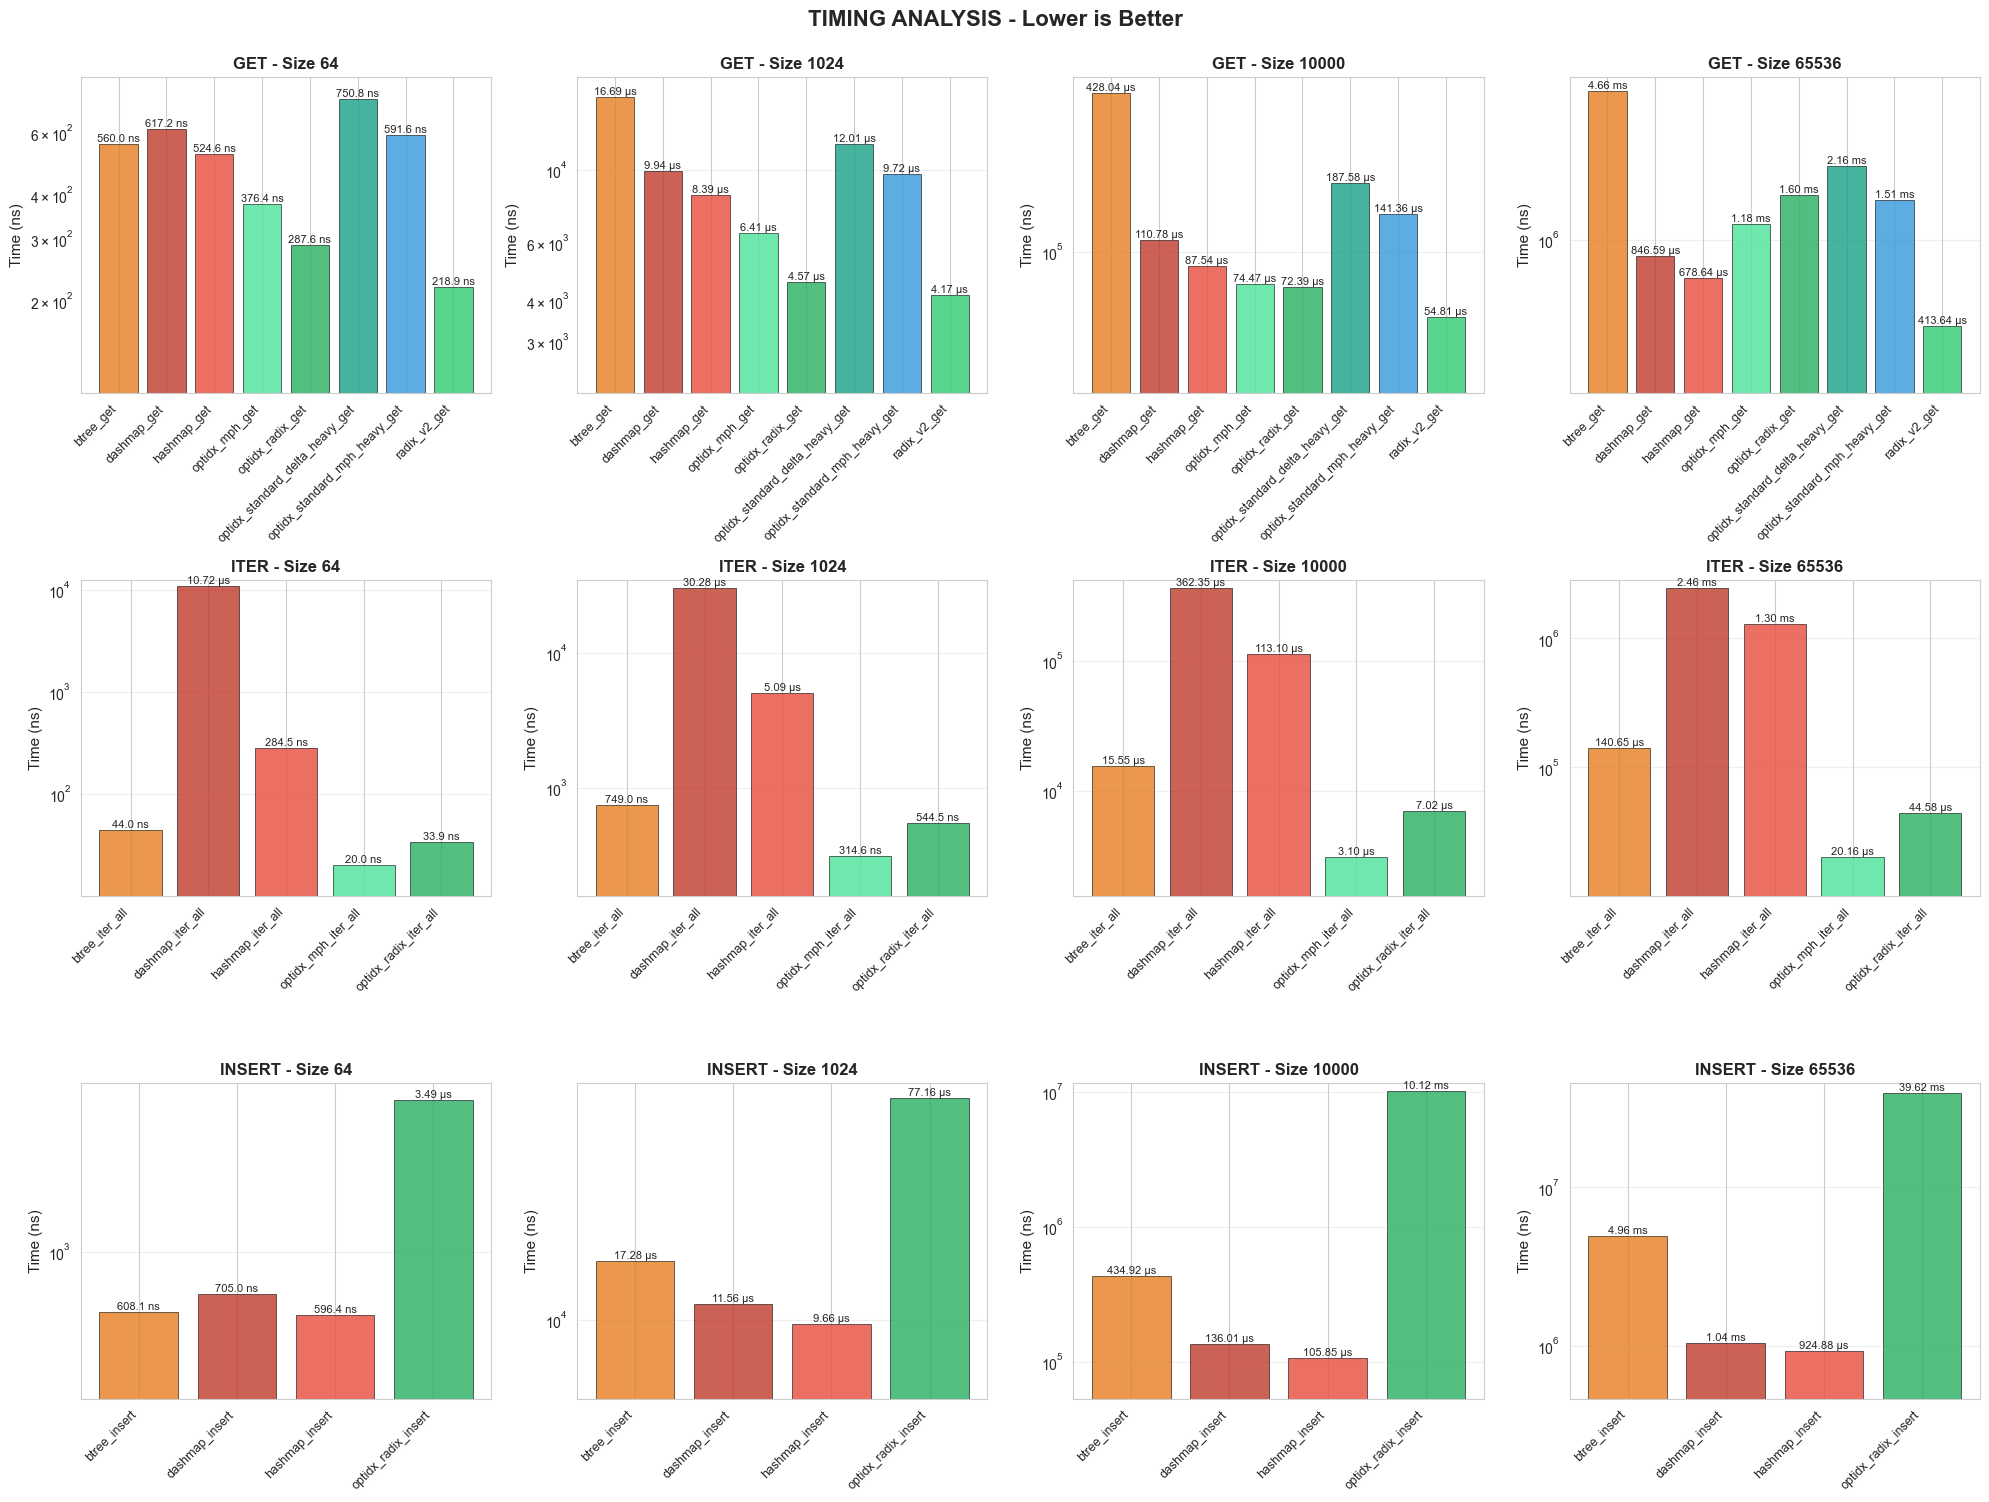

In [28]:
# Cell 6: Visual charts for GET, ITER, and INSERT operations - TIME (smaller is better)

# Get unique sizes (sorted) - handle both string and numeric types
sizes = []
for s in df_get_latest['size'].unique():
    try:
        # Try to convert to int to check if it's numeric
        int_val = int(s)
        sizes.append(str(s))
    except (ValueError, TypeError):
        # Skip non-numeric sizes
        pass
sizes = sorted(sizes, key=int)
num_sizes = len(sizes)

# Create subplots: 3 rows (GET, ITER, INSERT), one column per size
fig, axes = plt.subplots(3, num_sizes, figsize=(5 * num_sizes, 15))

# Add main title to the figure
fig.suptitle('TIMING ANALYSIS - Lower is Better', fontsize=16, fontweight='bold', y=0.998)

# Ensure axes is 2D even with single size
if num_sizes == 1:
    axes = axes.reshape(3, 1)

# Helper function to apply Y_MIN setting
def apply_y_min(ax, values, use_log=False):
    """Apply Y_MIN setting to control y-axis minimum"""
    if Y_MIN == "auto":
        return  # Let matplotlib auto-fit
    
    try:
        y_min_factor = float(Y_MIN)
        if 0 <= y_min_factor <= 1:
            min_val = min(values)
            max_val = max(values)
            
            # Calculate y_min based on factor
            # 0 = start at 0, 1 = start at min_val
            y_min = min_val * y_min_factor
            
            # For log scale, ensure y_min is positive
            if use_log and y_min <= 0:
                y_min = min_val * 0.1  # Use 10% of min value for log scale
            
            # Set limits with some padding at the top
            y_max = max_val * 1.15  # 15% padding
            ax.set_ylim(bottom=y_min, top=y_max)
    except (ValueError, TypeError):
        pass  # Invalid Y_MIN value, skip

# Define colors for different operation types
def get_color(operation):
    if 'optidx_standard_mph_heavy' in operation:
        return '#3498db'  # Bright blue - MPH heavy variant
    elif 'optidx_standard_delta_heavy' in operation:
        return '#16a085'  # Teal - Delta heavy variant
    elif 'optidx_mph' in operation:
        return '#4be399'  # Light green - Regular MPH
    elif 'radix_v2' in operation:
        return '#2ecc71'  # Bright green - Radix V2
    elif 'optidx_delta' in operation or 'optidx_radix' in operation:
        return '#27ae60'  # Dark green - Regular Radix
    elif 'hashmap' in operation:
        return '#e74c3c'  # Red
    elif 'dashmap' in operation:
        return '#c0392b'  # Dark red
    elif 'btree' in operation:
        return '#e67e22'  # Orange-red
    else:
        return '#95a5a6'  # Gray

# ============================================================================
# GET OPERATIONS - Column charts for each size
# ============================================================================

for idx, size in enumerate(sizes):
    ax = axes[0, idx]
    
    # Convert size to int for comparison (sizes list has strings, df has ints)
    size_int = int(size)
    
    # Filter data for this size
    size_data = df_get_latest[df_get_latest['size'] == size_int].sort_values('operation')
        
    if len(size_data) > 0:
        operations = size_data['operation'].tolist()
        times = size_data['median_ns'].tolist()
        colors = [get_color(op) for op in operations]
        
        # Create bar chart
        bars = ax.bar(range(len(operations)), times, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize
        ax.set_xticks(range(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Time (ns)', fontsize=11)
        ax.set_title(f'GET - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Apply Y_MIN setting
        apply_y_min(ax, times, use_log=(Y_SCALE == 'log'))
        
        # Add value labels on bars
        for i, (bar, time) in enumerate(zip(bars, times)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   format_time_human(time),
                   ha='center', va='bottom', fontsize=8, rotation=0)

# ============================================================================
# ITER OPERATIONS - Column charts for each size
# ============================================================================

for idx, size in enumerate(sizes):
    ax = axes[1, idx]
    
    # Convert size to int for comparison (sizes list has strings, df has ints)
    size_int = int(size)
    
    # Filter data for this size
    size_data = df_iter_latest[df_iter_latest['size'] == size_int].sort_values('operation')
    
    if len(size_data) > 0:
        operations = size_data['operation'].tolist()
        times = size_data['median_ns'].tolist()
        colors = [get_color(op) for op in operations]
        
        # Create bar chart
        bars = ax.bar(range(len(operations)), times, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize
        ax.set_xticks(range(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Time (ns)', fontsize=11)
        ax.set_title(f'ITER - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Apply Y_MIN setting
        apply_y_min(ax, times, use_log=(Y_SCALE == 'log'))
        
        # Add value labels on bars
        for i, (bar, time) in enumerate(zip(bars, times)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   format_time_human(time),
                   ha='center', va='bottom', fontsize=8, rotation=0)

# ============================================================================
# INSERT OPERATIONS - Column charts for each size
# ============================================================================

for idx, size in enumerate(sizes):
    ax = axes[2, idx]
    
    # Convert size to int for comparison (sizes list has strings, df has ints)
    size_int = int(size)
    
    # Filter data for this size
    size_data = df_insert_latest[df_insert_latest['size'] == size_int].sort_values('operation')
    
    if len(size_data) > 0:
        operations = size_data['operation'].tolist()
        times = size_data['median_ns'].tolist()
        colors = [get_color(op) for op in operations]
        
        # Create bar chart
        bars = ax.bar(range(len(operations)), times, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize
        ax.set_xticks(range(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Time (ns)', fontsize=11)
        ax.set_title(f'INSERT - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Apply Y_MIN setting
        apply_y_min(ax, times, use_log=(Y_SCALE == 'log'))
        
        # Add value labels on bars
        for i, (bar, time) in enumerate(zip(bars, times)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   format_time_human(time),
                   ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


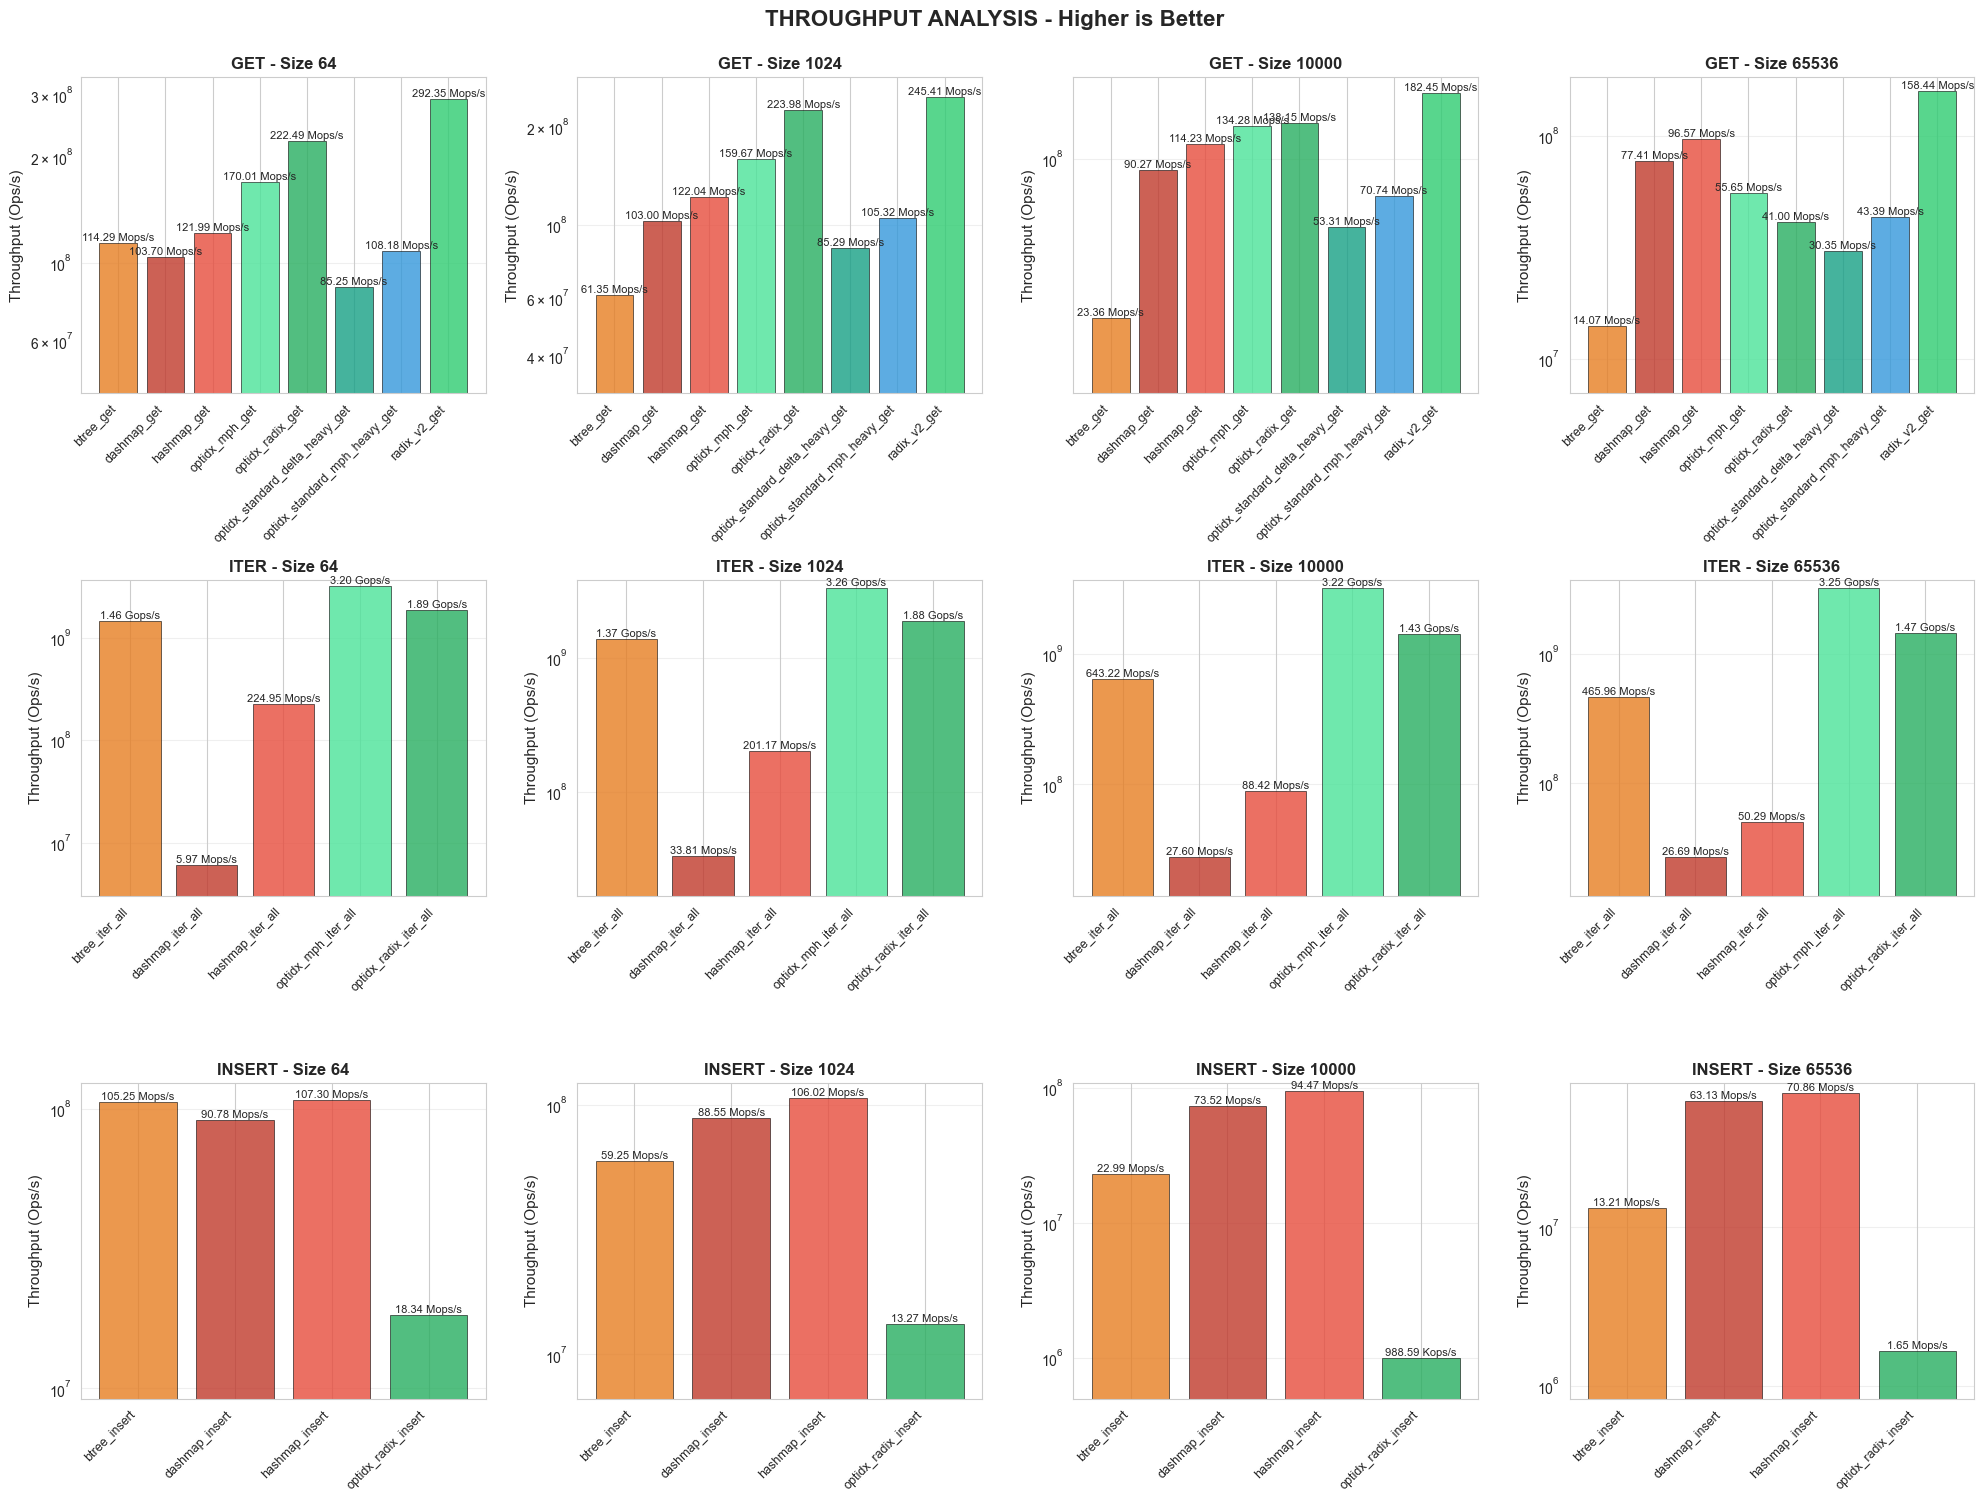

In [29]:
# Cell 7: Visual charts for Throughput (Ops/s) - THROUGHPUT (higher is better)

# Create subplots: 3 rows (GET, ITER, INSERT), one column per size
fig2, axes2 = plt.subplots(3, num_sizes, figsize=(5 * num_sizes, 15))

# Add main title to the figure
fig2.suptitle('THROUGHPUT ANALYSIS - Higher is Better', fontsize=16, fontweight='bold', y=0.998)

# Ensure axes is 2D even with single size
if num_sizes == 1:
    axes2 = axes2.reshape(3, 1)

# ============================================================================
# GET OPERATIONS - Throughput charts for each size
# ============================================================================

for idx, size in enumerate(sizes):
    ax = axes2[0, idx]
    
    # Convert size to int for comparison
    size_int = int(size)
    
    # Filter data for this size (sort alphabetically)
    size_data = df_get_latest[df_get_latest['size'] == size_int].sort_values('operation')
    
    if len(size_data) > 0:
        operations = size_data['operation'].tolist()
        throughput = size_data['throughput_ops_sec'].tolist()
        colors = [get_color(op) for op in operations]
        
        # Create bar chart
        bars = ax.bar(range(len(operations)), throughput, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize
        ax.set_xticks(range(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Throughput (Ops/s)', fontsize=11)
        ax.set_title(f'GET - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Apply Y_MIN setting
        apply_y_min(ax, throughput, use_log=(Y_SCALE == 'log'))
        
        # Add value labels on bars
        for i, (bar, tp, tp_pretty) in enumerate(zip(bars, throughput, size_data['throughput_pretty'])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   tp_pretty,
                   ha='center', va='bottom', fontsize=8, rotation=0)

# ============================================================================
# ITER OPERATIONS - Throughput charts for each size
# ============================================================================

for idx, size in enumerate(sizes):
    ax = axes2[1, idx]
    
    # Convert size to int for comparison
    size_int = int(size)
    
    # Filter data for this size (sort alphabetically)
    size_data = df_iter_latest[df_iter_latest['size'] == size_int].sort_values('operation')
    
    if len(size_data) > 0:
        operations = size_data['operation'].tolist()
        throughput = size_data['throughput_ops_sec'].tolist()
        colors = [get_color(op) for op in operations]
        
        # Create bar chart
        bars = ax.bar(range(len(operations)), throughput, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize
        ax.set_xticks(range(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Throughput (Ops/s)', fontsize=11)
        ax.set_title(f'ITER - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Apply Y_MIN setting
        apply_y_min(ax, throughput, use_log=(Y_SCALE == 'log'))
        
        # Add value labels on bars
        for i, (bar, tp, tp_pretty) in enumerate(zip(bars, throughput, size_data['throughput_pretty'])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   tp_pretty,
                   ha='center', va='bottom', fontsize=8, rotation=0)

# ============================================================================
# INSERT OPERATIONS - Throughput charts for each size
# ============================================================================

for idx, size in enumerate(sizes):
    ax = axes2[2, idx]
    
    # Convert size to int for comparison
    size_int = int(size)
    
    # Filter data for this size (sort alphabetically)
    size_data = df_insert_latest[df_insert_latest['size'] == size_int].sort_values('operation')
    
    if len(size_data) > 0:
        operations = size_data['operation'].tolist()
        throughput = size_data['throughput_ops_sec'].tolist()
        colors = [get_color(op) for op in operations]
        
        # Create bar chart
        bars = ax.bar(range(len(operations)), throughput, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize
        ax.set_xticks(range(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Throughput (Ops/s)', fontsize=11)
        ax.set_title(f'INSERT - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, axis=  'y', alpha=0.3)
        
        # Apply Y_MIN setting
        apply_y_min(ax, throughput, use_log=(Y_SCALE == 'log'))
        
        # Add value labels on bars
        for i, (bar, tp, tp_pretty) in enumerate(zip(bars, throughput, size_data['throughput_pretty'])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   tp_pretty,
                   ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


# Time Series Analysis - Custom Indexes

The following cells analyze performance trends over time for the Radix and MPH indexes specifically.
Each chart shows progression across multiple benchmark runs, with different lines for each index size.


In [30]:
# Cell 8: Prepare data for time series analysis

# Filter for custom indexes only (Radix and MPH)
df_radix = df_compare_get[df_compare_get['operation'].str.contains('optidx_radix', na=False)].copy()
df_mph = df_compare_get[df_compare_get['operation'].str.contains('optidx_mph', na=False)].copy()

# Filter for radix_v2 index
df_radix_v2 = df_compare_get[df_compare_get['operation'].str.contains('radix_v2', na=False)].copy()

# Filter for standard optimised index variants
df_standard_mph = df_compare_get[df_compare_get['operation'].str.contains('optidx_standard_mph_heavy', na=False)].copy()
df_standard_delta = df_compare_get[df_compare_get['operation'].str.contains('optidx_standard_delta_heavy', na=False)].copy()

# Separate get and iter for each
df_radix_get = df_radix[df_radix['operation'].str.contains('get', case=False, na=False) & 
                         ~df_radix['operation'].str.contains('iter', case=False, na=False)].copy()
df_radix_iter = df_radix[df_radix['operation'].str.contains('iter', case=False, na=False)].copy()

df_mph_get = df_mph[df_mph['operation'].str.contains('get', case=False, na=False) & 
                     ~df_mph['operation'].str.contains('iter', case=False, na=False)].copy()
df_mph_iter = df_mph[df_mph['operation'].str.contains('iter', case=False, na=False)].copy()

df_radix_v2_get = df_radix_v2[df_radix_v2['operation'].str.contains('get', case=False, na=False) & 
                               ~df_radix_v2['operation'].str.contains('iter', case=False, na=False)].copy()
df_radix_v2_iter = df_radix_v2[df_radix_v2['operation'].str.contains('iter', case=False, na=False)].copy()

df_standard_mph_get = df_standard_mph[df_standard_mph['operation'].str.contains('get', case=False, na=False) & 
                                       ~df_standard_mph['operation'].str.contains('iter', case=False, na=False)].copy()
df_standard_mph_iter = df_standard_mph[df_standard_mph['operation'].str.contains('iter', case=False, na=False)].copy()

df_standard_delta_get = df_standard_delta[df_standard_delta['operation'].str.contains('get', case=False, na=False) & 
                                           ~df_standard_delta['operation'].str.contains('iter', case=False, na=False)].copy()
df_standard_delta_iter = df_standard_delta[df_standard_delta['operation'].str.contains('iter', case=False, na=False)].copy()

# Show unique sizes

# Function to limit records per size based on LAST_N
def limit_records(df_subset, last_n=None):
    """Limit dataframe to last N records per size, or all if last_n is None"""
    if last_n is None:
        return df_subset
    
    # Sort by timestamp and take last N per size
    result = df_subset.sort_values('timestamp').groupby('size').tail(last_n)
    return result.sort_values(['size', 'timestamp'])

# Apply limit to all datasets
df_radix_get_limited = limit_records(df_radix_get, LAST_N)
df_radix_iter_limited = limit_records(df_radix_iter, LAST_N)
df_mph_get_limited = limit_records(df_mph_get, LAST_N)
df_mph_iter_limited = limit_records(df_mph_iter, LAST_N)
df_radix_v2_get_limited = limit_records(df_radix_v2_get, LAST_N)
df_radix_v2_iter_limited = limit_records(df_radix_v2_iter, LAST_N)
df_standard_mph_get_limited = limit_records(df_standard_mph_get, LAST_N)
df_standard_mph_iter_limited = limit_records(df_standard_mph_iter, LAST_N)
df_standard_delta_get_limited = limit_records(df_standard_delta_get, LAST_N)
df_standard_delta_iter_limited = limit_records(df_standard_delta_iter, LAST_N)



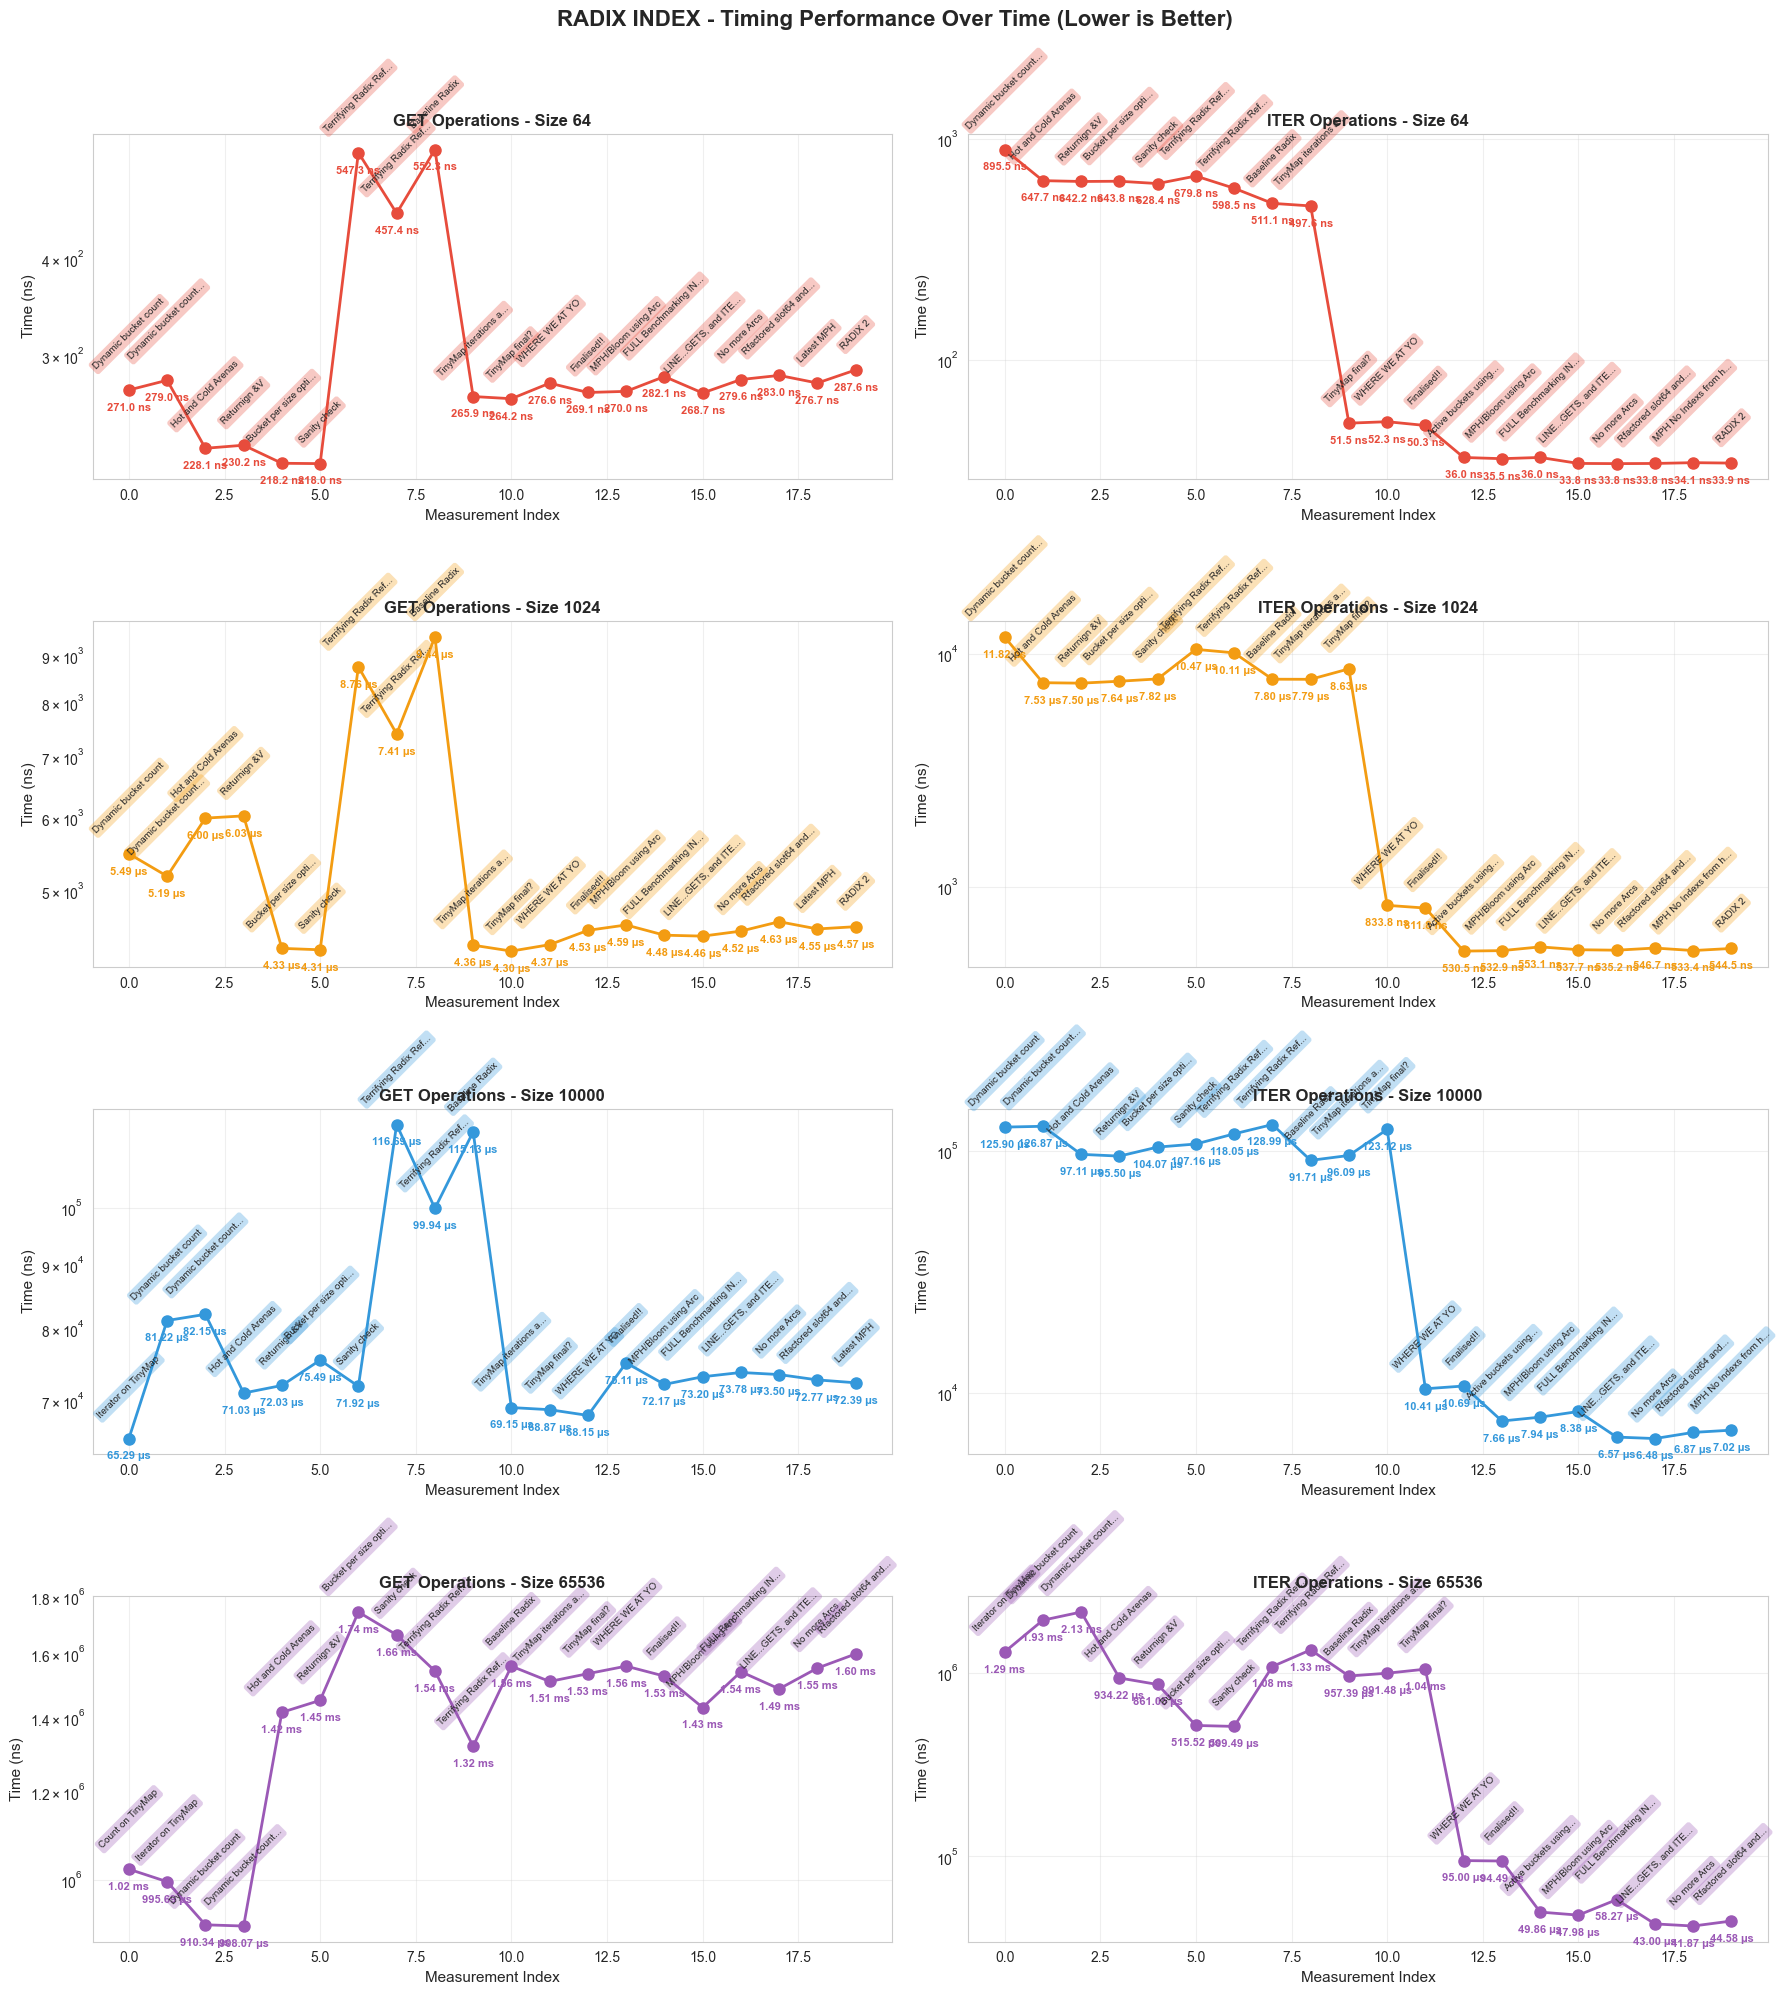

In [31]:
# Cell 9: RADIX INDEX - Time Series Timing Analysis (Lower is Better)

# Color map for different sizes
size_colors = {
    64: '#e74c3c',      # Red
    1024: '#f39c12',    # Orange
    10000: '#3498db',   # Blue
    65536: '#9b59b6'    # Purple
}

# Get unique sizes
sizes = sorted(df_radix_get_limited['size'].unique())
num_sizes = len(sizes)

# Create subplots: one row per size, 2 columns (GET, ITER)
fig, axes = plt.subplots(num_sizes, 2, figsize=(18, 5 * num_sizes))
fig.suptitle('RADIX INDEX - Timing Performance Over Time (Lower is Better)', 
             fontsize=16, fontweight='bold', y=0.995)

# Ensure axes is 2D even with single size
if num_sizes == 1:
    axes = axes.reshape(1, 2)

# ============================================================================
# Loop through each size and create GET and ITER charts
# ============================================================================
for row_idx, size in enumerate(sizes):
    color = size_colors.get(size, '#95a5a6')
    
    # GET Operations (left column)
    ax_get = axes[row_idx, 0]
    size_data_get = df_radix_get_limited[df_radix_get_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_get) > 0:
        # Plot line
        ax_get.plot(range(len(size_data_get)), size_data_get['median_ns'], 
                   marker='o', linewidth=2, markersize=8,
                   color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag) in enumerate(zip(range(len(size_data_get)), 
                                               size_data_get['median_ns'], 
                                               size_data_get['tag'])):
            # Add value label (closer to point)
            value_label = format_time_human(y)
            ax_get.annotate(value_label, (x, y), 
                           textcoords="offset points", xytext=(0, -15),
                           ha='center', fontsize=8, fontweight='bold',
                           color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_get.annotate(tag_short, (x, y), 
                           textcoords="offset points", xytext=(0, 15),
                           ha='center', fontsize=7, rotation=45,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                    alpha=0.3, edgecolor='none'))
    
    ax_get.set_xlabel('Measurement Index', fontsize=11)
    ax_get.set_ylabel('Time (ns)', fontsize=11)
    ax_get.set_title(f'GET Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_get.grid(True, alpha=0.3)
    ax_get.set_yscale(Y_SCALE)
    
    # ITER Operations (right column)
    ax_iter = axes[row_idx, 1]
    size_data_iter = df_radix_iter_limited[df_radix_iter_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_iter) > 0:
        # Plot line
        ax_iter.plot(range(len(size_data_iter)), size_data_iter['median_ns'], 
                    marker='o', linewidth=2, markersize=8,
                    color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag) in enumerate(zip(range(len(size_data_iter)), 
                                               size_data_iter['median_ns'], 
                                               size_data_iter['tag'])):
            # Add value label (closer to point)
            value_label = format_time_human(y)
            ax_iter.annotate(value_label, (x, y), 
                            textcoords="offset points", xytext=(0, -15),
                            ha='center', fontsize=8, fontweight='bold',
                            color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_iter.annotate(tag_short, (x, y), 
                            textcoords="offset points", xytext=(0, 15),
                            ha='center', fontsize=7, rotation=45,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                     alpha=0.3, edgecolor='none'))
    
    ax_iter.set_xlabel('Measurement Index', fontsize=11)
    ax_iter.set_ylabel('Time (ns)', fontsize=11)
    ax_iter.set_title(f'ITER Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_iter.grid(True, alpha=0.3)
    ax_iter.set_yscale(Y_SCALE)

plt.tight_layout()
plt.show()


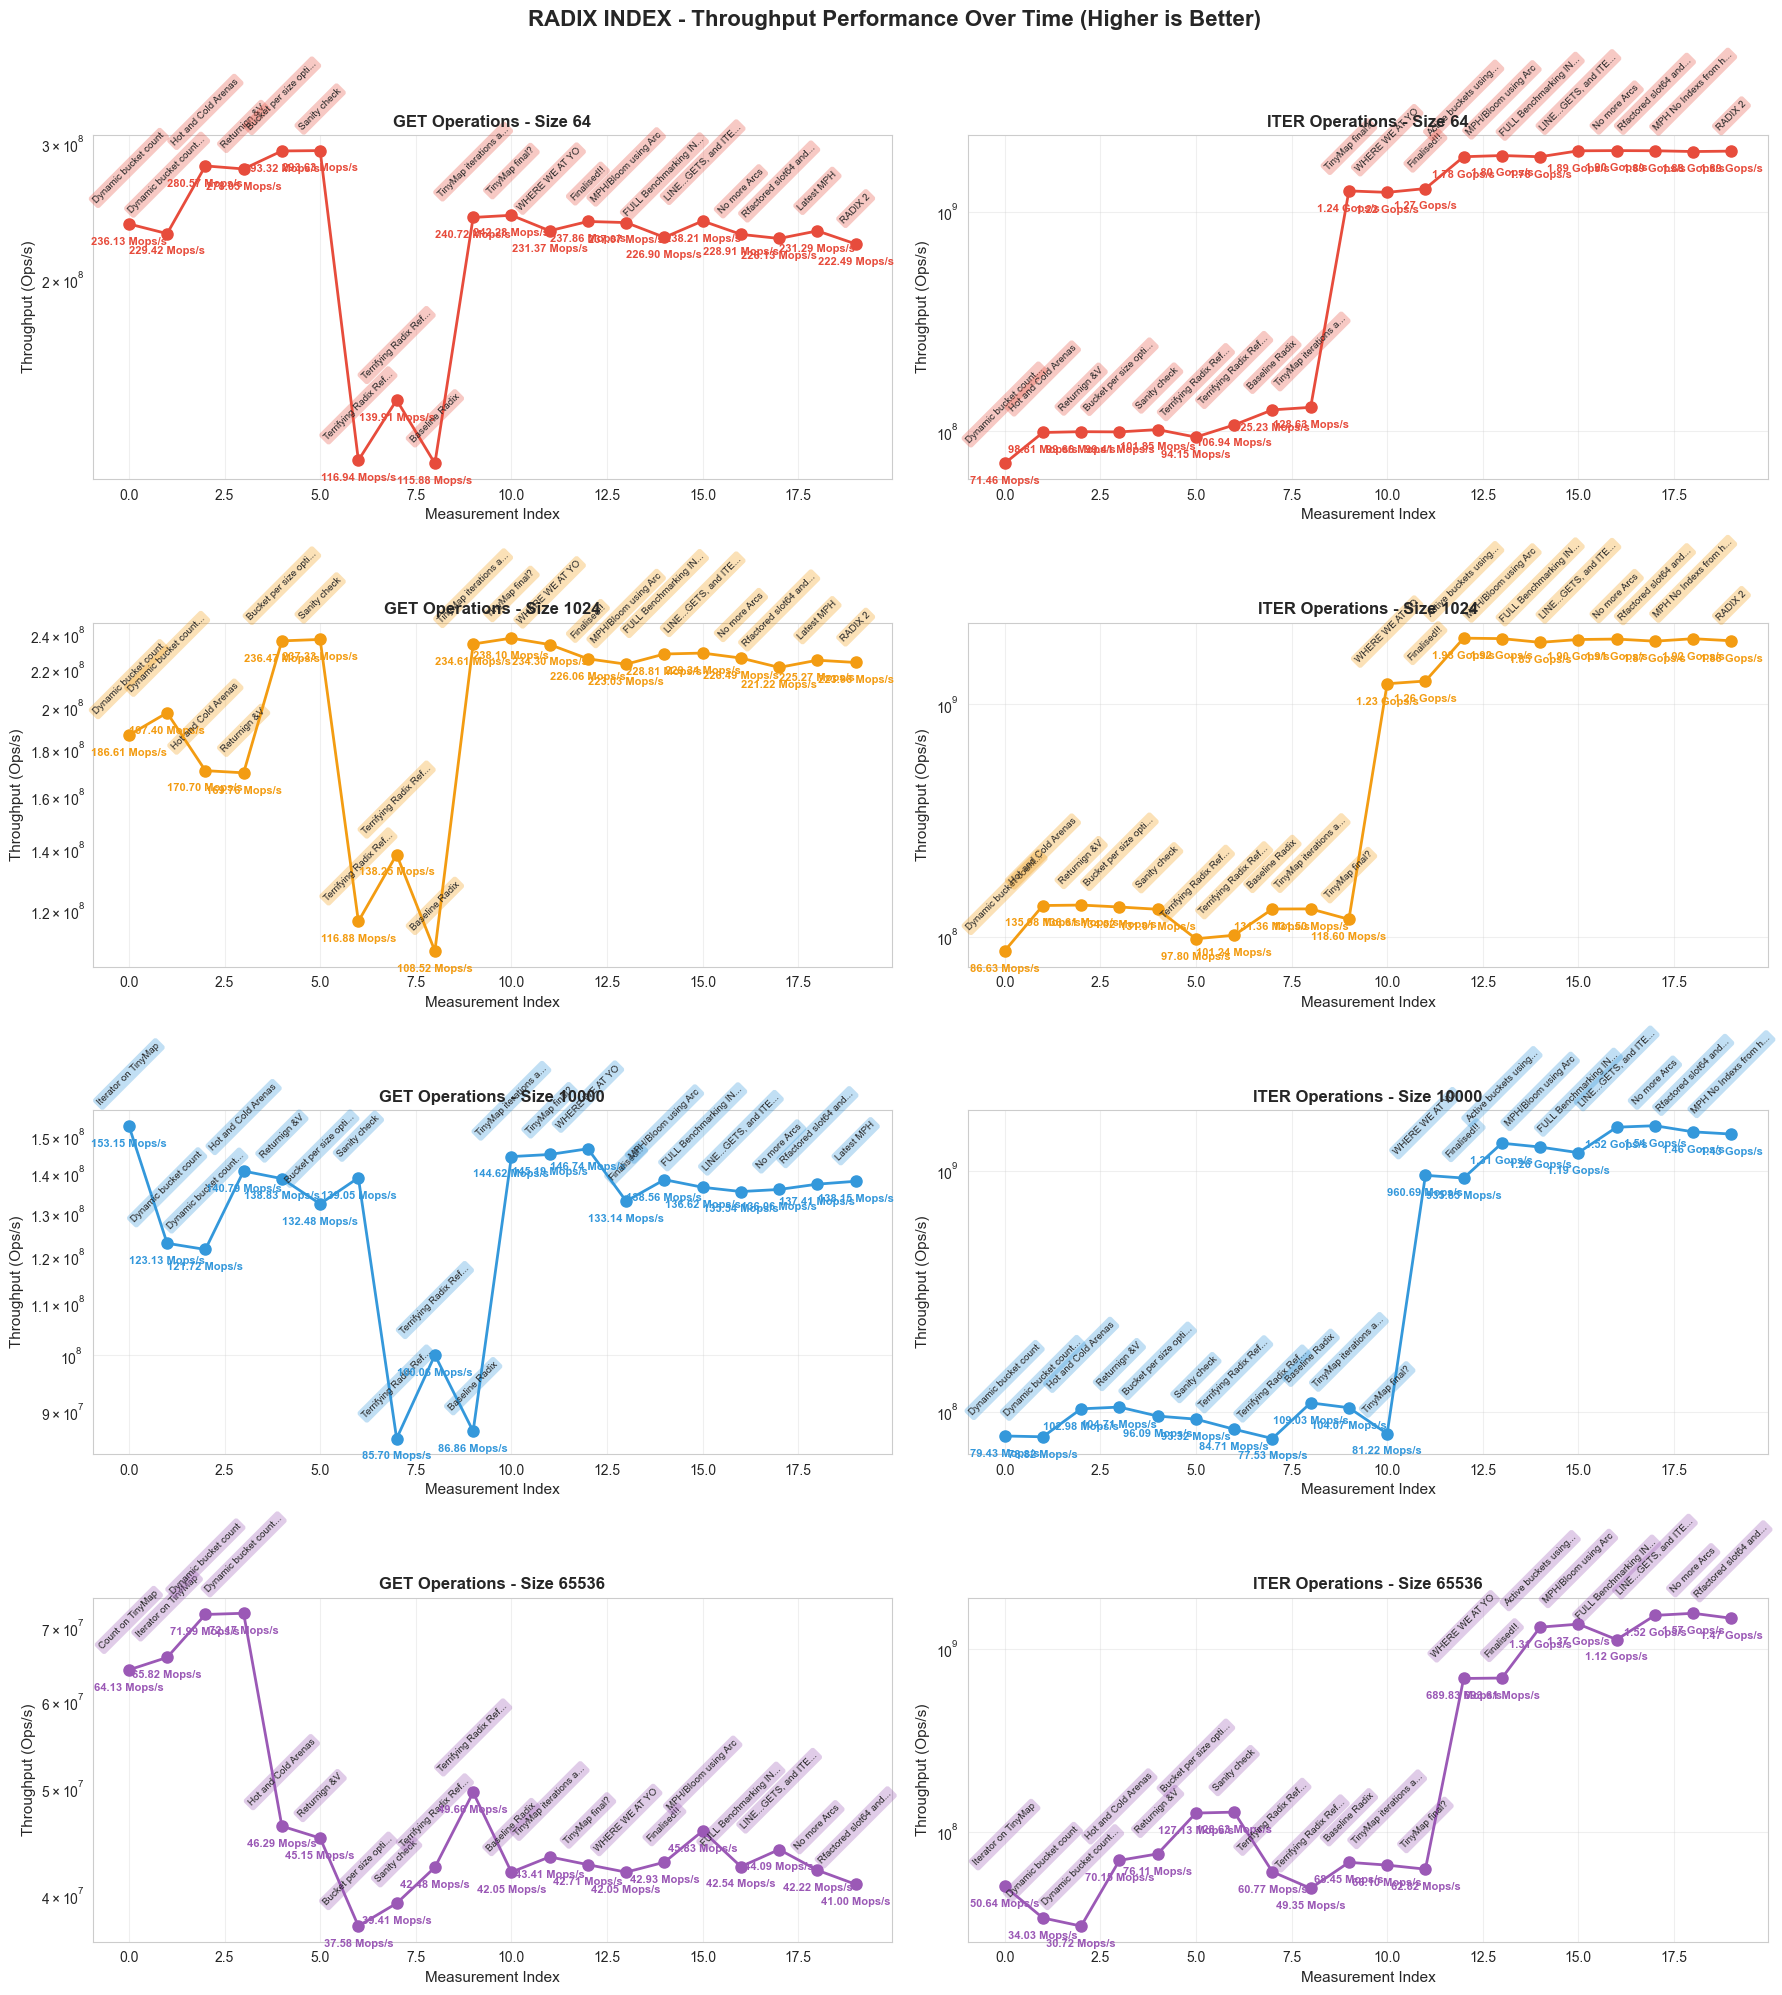

In [32]:
# Cell 10: RADIX INDEX - Time Series Throughput Analysis (Higher is Better)

# Get unique sizes
sizes = sorted(df_radix_get_limited['size'].unique())
num_sizes = len(sizes)

# Create subplots: one row per size, 2 columns (GET, ITER)
fig, axes = plt.subplots(num_sizes, 2, figsize=(18, 5 * num_sizes))
fig.suptitle('RADIX INDEX - Throughput Performance Over Time (Higher is Better)', 
             fontsize=16, fontweight='bold', y=0.995)

# Ensure axes is 2D even with single size
if num_sizes == 1:
    axes = axes.reshape(1, 2)

# ============================================================================
# Loop through each size and create GET and ITER charts
# ============================================================================
for row_idx, size in enumerate(sizes):
    color = size_colors.get(size, '#95a5a6')
    
    # GET Operations (left column)
    ax_get = axes[row_idx, 0]
    size_data_get = df_radix_get_limited[df_radix_get_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_get) > 0:
        # Plot line
        ax_get.plot(range(len(size_data_get)), size_data_get['throughput_ops_sec'], 
                   marker='o', linewidth=2, markersize=8,
                   color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag, tp_pretty) in enumerate(zip(range(len(size_data_get)), 
                                               size_data_get['throughput_ops_sec'], 
                                               size_data_get['tag'],
                                               size_data_get['throughput_pretty'])):
            # Add value label (closer to point)
            ax_get.annotate(tp_pretty, (x, y), 
                           textcoords="offset points", xytext=(0, -15),
                           ha='center', fontsize=8, fontweight='bold',
                           color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_get.annotate(tag_short, (x, y), 
                           textcoords="offset points", xytext=(0, 15),
                           ha='center', fontsize=7, rotation=45,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                    alpha=0.3, edgecolor='none'))
    
    ax_get.set_xlabel('Measurement Index', fontsize=11)
    ax_get.set_ylabel('Throughput (Ops/s)', fontsize=11)
    ax_get.set_title(f'GET Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_get.grid(True, alpha=0.3)
    ax_get.set_yscale(Y_SCALE)
    
    # ITER Operations (right column)
    ax_iter = axes[row_idx, 1]
    size_data_iter = df_radix_iter_limited[df_radix_iter_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_iter) > 0:
        # Plot line
        ax_iter.plot(range(len(size_data_iter)), size_data_iter['throughput_ops_sec'], 
                    marker='o', linewidth=2, markersize=8,
                    color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag, tp_pretty) in enumerate(zip(range(len(size_data_iter)), 
                                               size_data_iter['throughput_ops_sec'], 
                                               size_data_iter['tag'],
                                               size_data_iter['throughput_pretty'])):
            # Add value label (closer to point)
            ax_iter.annotate(tp_pretty, (x, y), 
                            textcoords="offset points", xytext=(0, -15),
                            ha='center', fontsize=8, fontweight='bold',
                            color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_iter.annotate(tag_short, (x, y), 
                            textcoords="offset points", xytext=(0, 15),
                            ha='center', fontsize=7, rotation=45,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                     alpha=0.3, edgecolor='none'))
    
    ax_iter.set_xlabel('Measurement Index', fontsize=11)
    ax_iter.set_ylabel('Throughput (Ops/s)', fontsize=11)
    ax_iter.set_title(f'ITER Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_iter.grid(True, alpha=0.3)
    ax_iter.set_yscale(Y_SCALE)

plt.tight_layout()
plt.show()


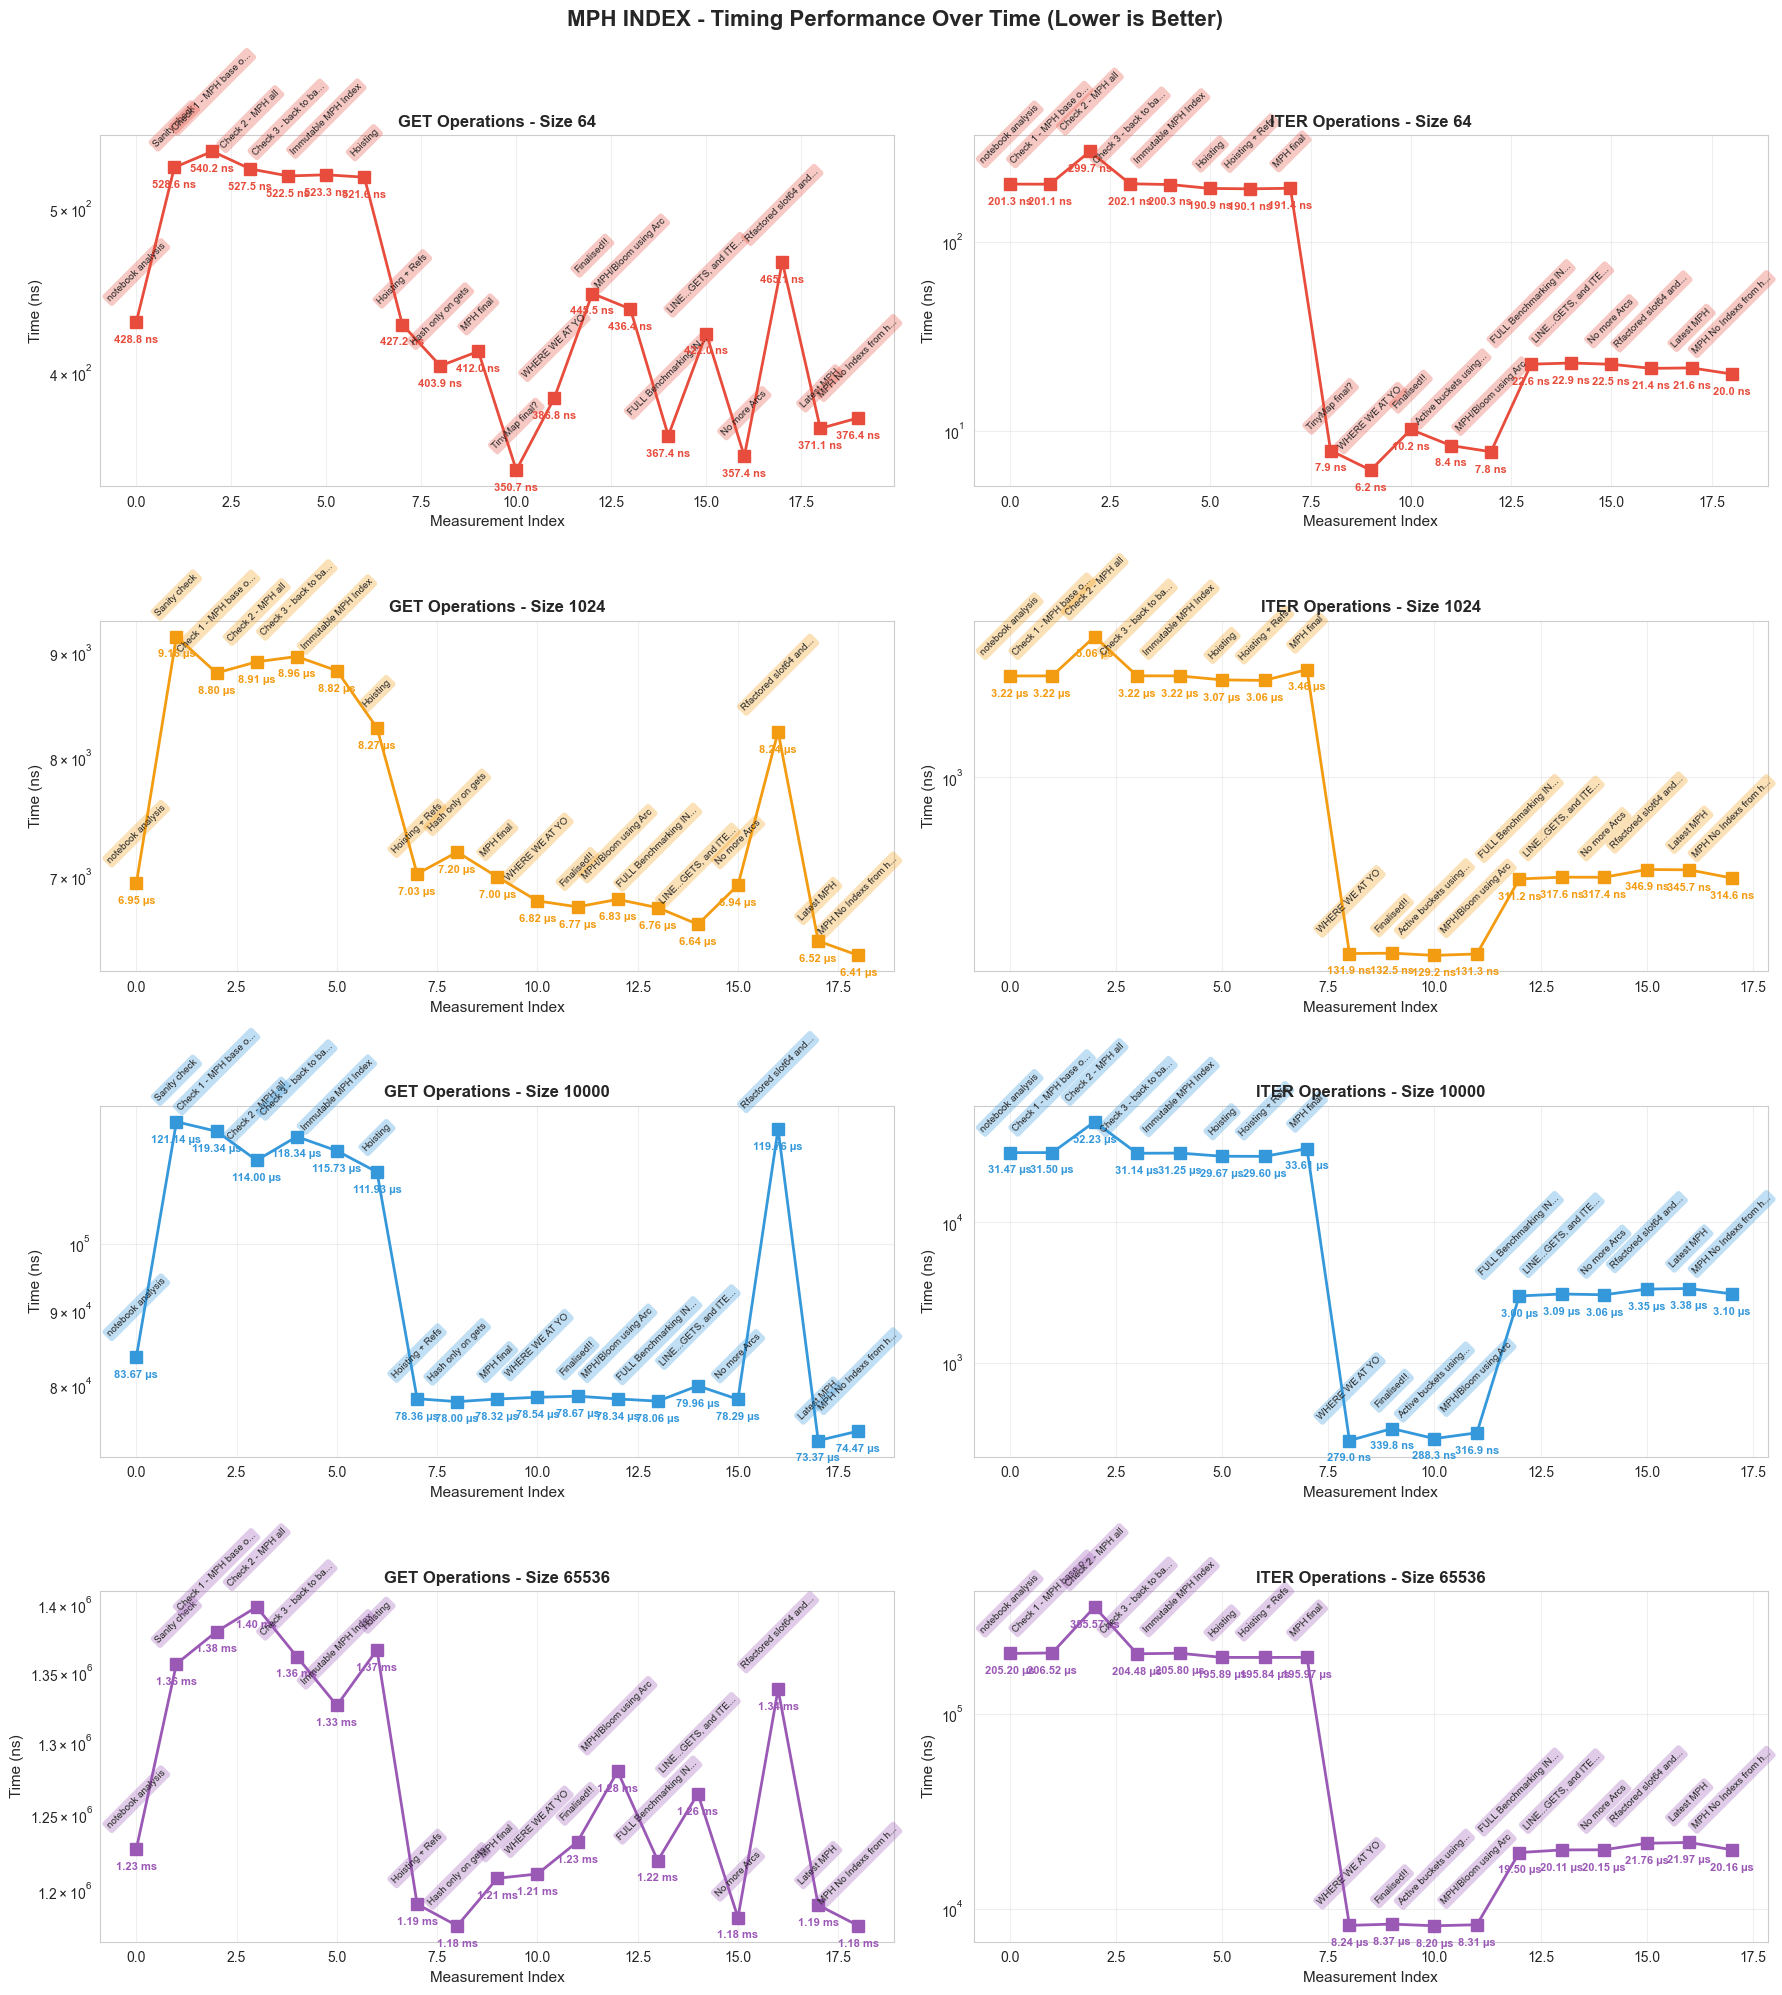

In [33]:
# Cell 11: MPH INDEX - Time Series Timing Analysis (Lower is Better)

# Get unique sizes
sizes = sorted(df_mph_get_limited['size'].unique())
num_sizes = len(sizes)

# Create subplots: one row per size, 2 columns (GET, ITER)
fig, axes = plt.subplots(num_sizes, 2, figsize=(18, 5 * num_sizes))
fig.suptitle('MPH INDEX - Timing Performance Over Time (Lower is Better)', 
             fontsize=16, fontweight='bold', y=0.995)

# Ensure axes is 2D even with single size
if num_sizes == 1:
    axes = axes.reshape(1, 2)

# ============================================================================
# Loop through each size and create GET and ITER charts
# ============================================================================
for row_idx, size in enumerate(sizes):
    color = size_colors.get(size, '#95a5a6')
    
    # GET Operations (left column)
    ax_get = axes[row_idx, 0]
    size_data_get = df_mph_get_limited[df_mph_get_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_get) > 0:
        # Plot line
        ax_get.plot(range(len(size_data_get)), size_data_get['median_ns'], 
                   marker='s', linewidth=2, markersize=8,
                   color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag) in enumerate(zip(range(len(size_data_get)), 
                                               size_data_get['median_ns'], 
                                               size_data_get['tag'])):
            # Add value label (closer to point)
            value_label = format_time_human(y)
            ax_get.annotate(value_label, (x, y), 
                           textcoords="offset points", xytext=(0, -15),
                           ha='center', fontsize=8, fontweight='bold',
                           color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_get.annotate(tag_short, (x, y), 
                           textcoords="offset points", xytext=(0, 15),
                           ha='center', fontsize=7, rotation=45,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                    alpha=0.3, edgecolor='none'))
    
    ax_get.set_xlabel('Measurement Index', fontsize=11)
    ax_get.set_ylabel('Time (ns)', fontsize=11)
    ax_get.set_title(f'GET Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_get.grid(True, alpha=0.3)
    ax_get.set_yscale(Y_SCALE)
    
    # ITER Operations (right column)
    ax_iter = axes[row_idx, 1]
    size_data_iter = df_mph_iter_limited[df_mph_iter_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_iter) > 0:
        # Plot line
        ax_iter.plot(range(len(size_data_iter)), size_data_iter['median_ns'], 
                    marker='s', linewidth=2, markersize=8,
                    color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag) in enumerate(zip(range(len(size_data_iter)), 
                                               size_data_iter['median_ns'], 
                                               size_data_iter['tag'])):
            # Add value label (closer to point)
            value_label = format_time_human(y)
            ax_iter.annotate(value_label, (x, y), 
                            textcoords="offset points", xytext=(0, -15),
                            ha='center', fontsize=8, fontweight='bold',
                            color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_iter.annotate(tag_short, (x, y), 
                            textcoords="offset points", xytext=(0, 15),
                            ha='center', fontsize=7, rotation=45,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                     alpha=0.3, edgecolor='none'))
    
    ax_iter.set_xlabel('Measurement Index', fontsize=11)
    ax_iter.set_ylabel('Time (ns)', fontsize=11)
    ax_iter.set_title(f'ITER Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_iter.grid(True, alpha=0.3)
    ax_iter.set_yscale(Y_SCALE)

plt.tight_layout()
plt.show()


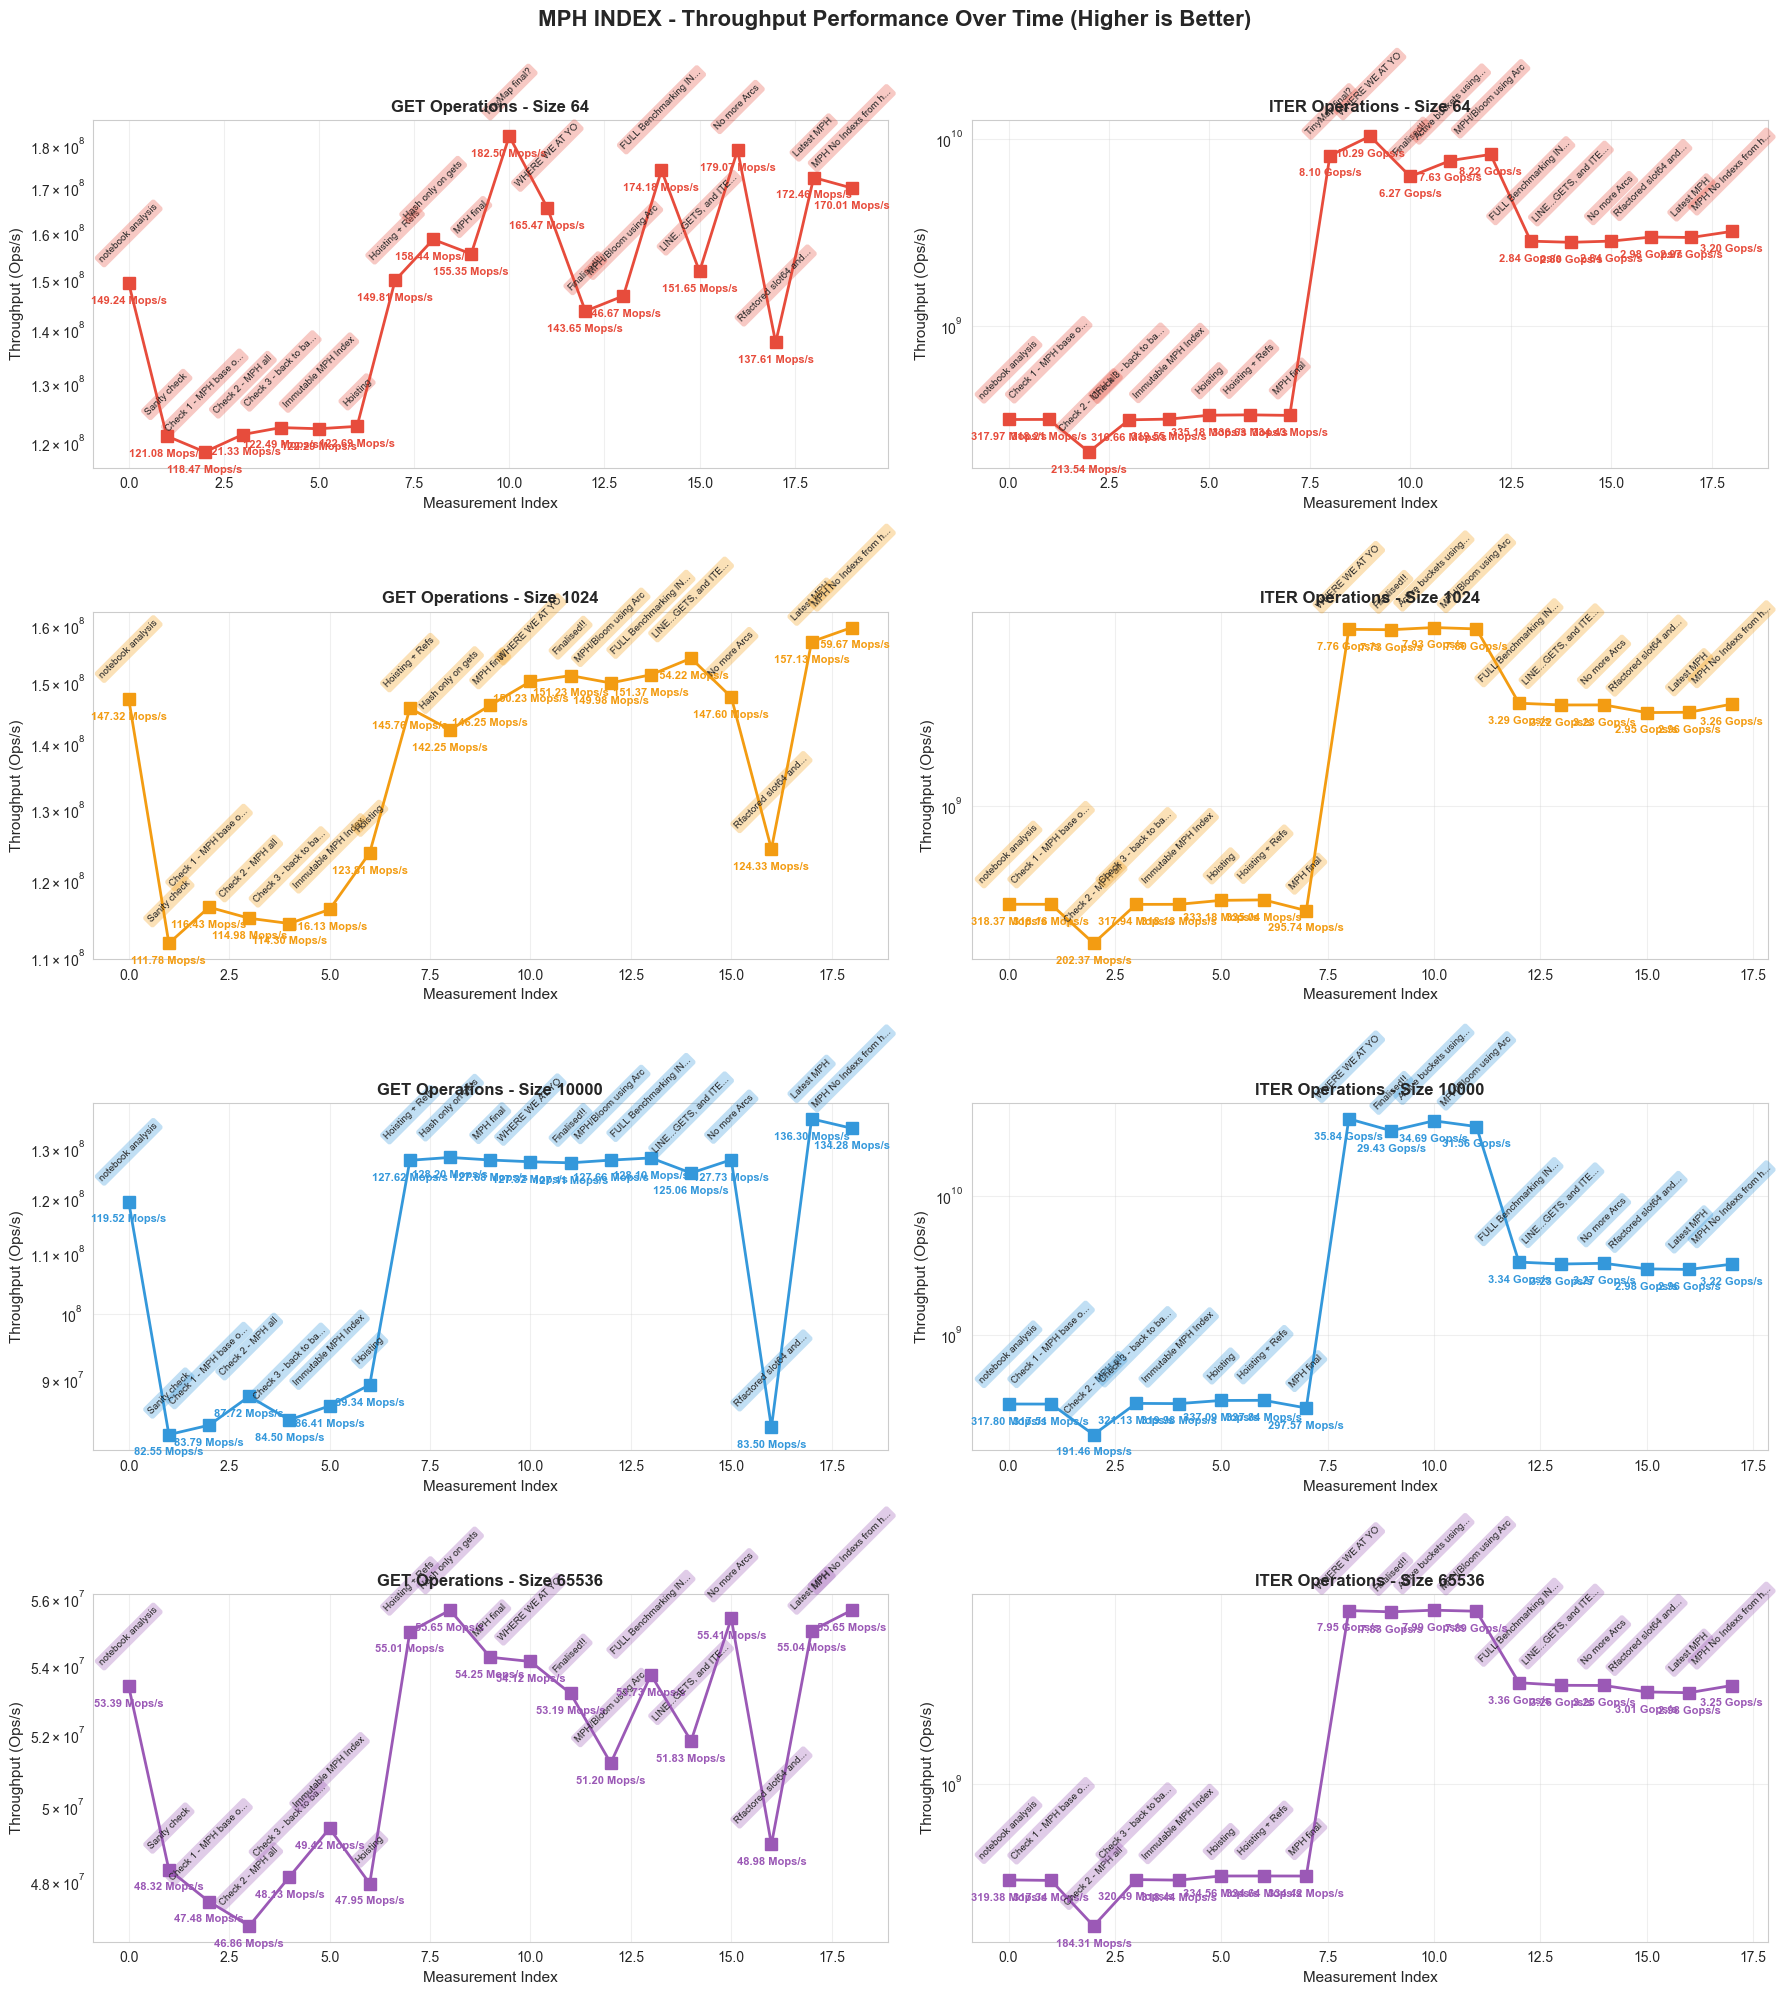

In [34]:
# Cell 12: MPH INDEX - Time Series Throughput Analysis (Higher is Better)

# Get unique sizes
sizes = sorted(df_mph_get_limited['size'].unique())
num_sizes = len(sizes)

# Create subplots: one row per size, 2 columns (GET, ITER)
fig, axes = plt.subplots(num_sizes, 2, figsize=(18, 5 * num_sizes))
fig.suptitle('MPH INDEX - Throughput Performance Over Time (Higher is Better)', 
             fontsize=16, fontweight='bold', y=0.995)

# Ensure axes is 2D even with single size
if num_sizes == 1:
    axes = axes.reshape(1, 2)

# ============================================================================
# Loop through each size and create GET and ITER charts
# ============================================================================
for row_idx, size in enumerate(sizes):
    color = size_colors.get(size, '#95a5a6')
    
    # GET Operations (left column)
    ax_get = axes[row_idx, 0]
    size_data_get = df_mph_get_limited[df_mph_get_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_get) > 0:
        # Plot line
        ax_get.plot(range(len(size_data_get)), size_data_get['throughput_ops_sec'], 
                   marker='s', linewidth=2, markersize=8,
                   color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag, tp_pretty) in enumerate(zip(range(len(size_data_get)), 
                                               size_data_get['throughput_ops_sec'], 
                                               size_data_get['tag'],
                                               size_data_get['throughput_pretty'])):
            # Add value label (closer to point)
            ax_get.annotate(tp_pretty, (x, y), 
                           textcoords="offset points", xytext=(0, -15),
                           ha='center', fontsize=8, fontweight='bold',
                           color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_get.annotate(tag_short, (x, y), 
                           textcoords="offset points", xytext=(0, 15),
                           ha='center', fontsize=7, rotation=45,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                    alpha=0.3, edgecolor='none'))
    
    ax_get.set_xlabel('Measurement Index', fontsize=11)
    ax_get.set_ylabel('Throughput (Ops/s)', fontsize=11)
    ax_get.set_title(f'GET Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_get.grid(True, alpha=0.3)
    ax_get.set_yscale(Y_SCALE)
    
    # ITER Operations (right column)
    ax_iter = axes[row_idx, 1]
    size_data_iter = df_mph_iter_limited[df_mph_iter_limited['size'] == size].sort_values('timestamp')
    
    if len(size_data_iter) > 0:
        # Plot line
        ax_iter.plot(range(len(size_data_iter)), size_data_iter['throughput_ops_sec'], 
                    marker='s', linewidth=2, markersize=8,
                    color=color, label=f'Size {size}')
        
        # Add value and tag labels at each point
        for idx, (x, y, tag, tp_pretty) in enumerate(zip(range(len(size_data_iter)), 
                                               size_data_iter['throughput_ops_sec'], 
                                               size_data_iter['tag'],
                                               size_data_iter['throughput_pretty'])):
            # Add value label (closer to point)
            ax_iter.annotate(tp_pretty, (x, y), 
                            textcoords="offset points", xytext=(0, -15),
                            ha='center', fontsize=8, fontweight='bold',
                            color=color)
            
            # Add tag label (further from point)
            tag_short = tag[:20] + '...' if len(tag) > 20 else tag
            ax_iter.annotate(tag_short, (x, y), 
                            textcoords="offset points", xytext=(0, 15),
                            ha='center', fontsize=7, rotation=45,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, 
                                     alpha=0.3, edgecolor='none'))
    
    ax_iter.set_xlabel('Measurement Index', fontsize=11)
    ax_iter.set_ylabel('Throughput (Ops/s)', fontsize=11)
    ax_iter.set_title(f'ITER Operations - Size {size}', fontsize=12, fontweight='bold')
    ax_iter.grid(True, alpha=0.3)
    ax_iter.set_yscale(Y_SCALE)

plt.tight_layout()
plt.show()


Creating consolidated timing chart for 4 sizes: [np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]


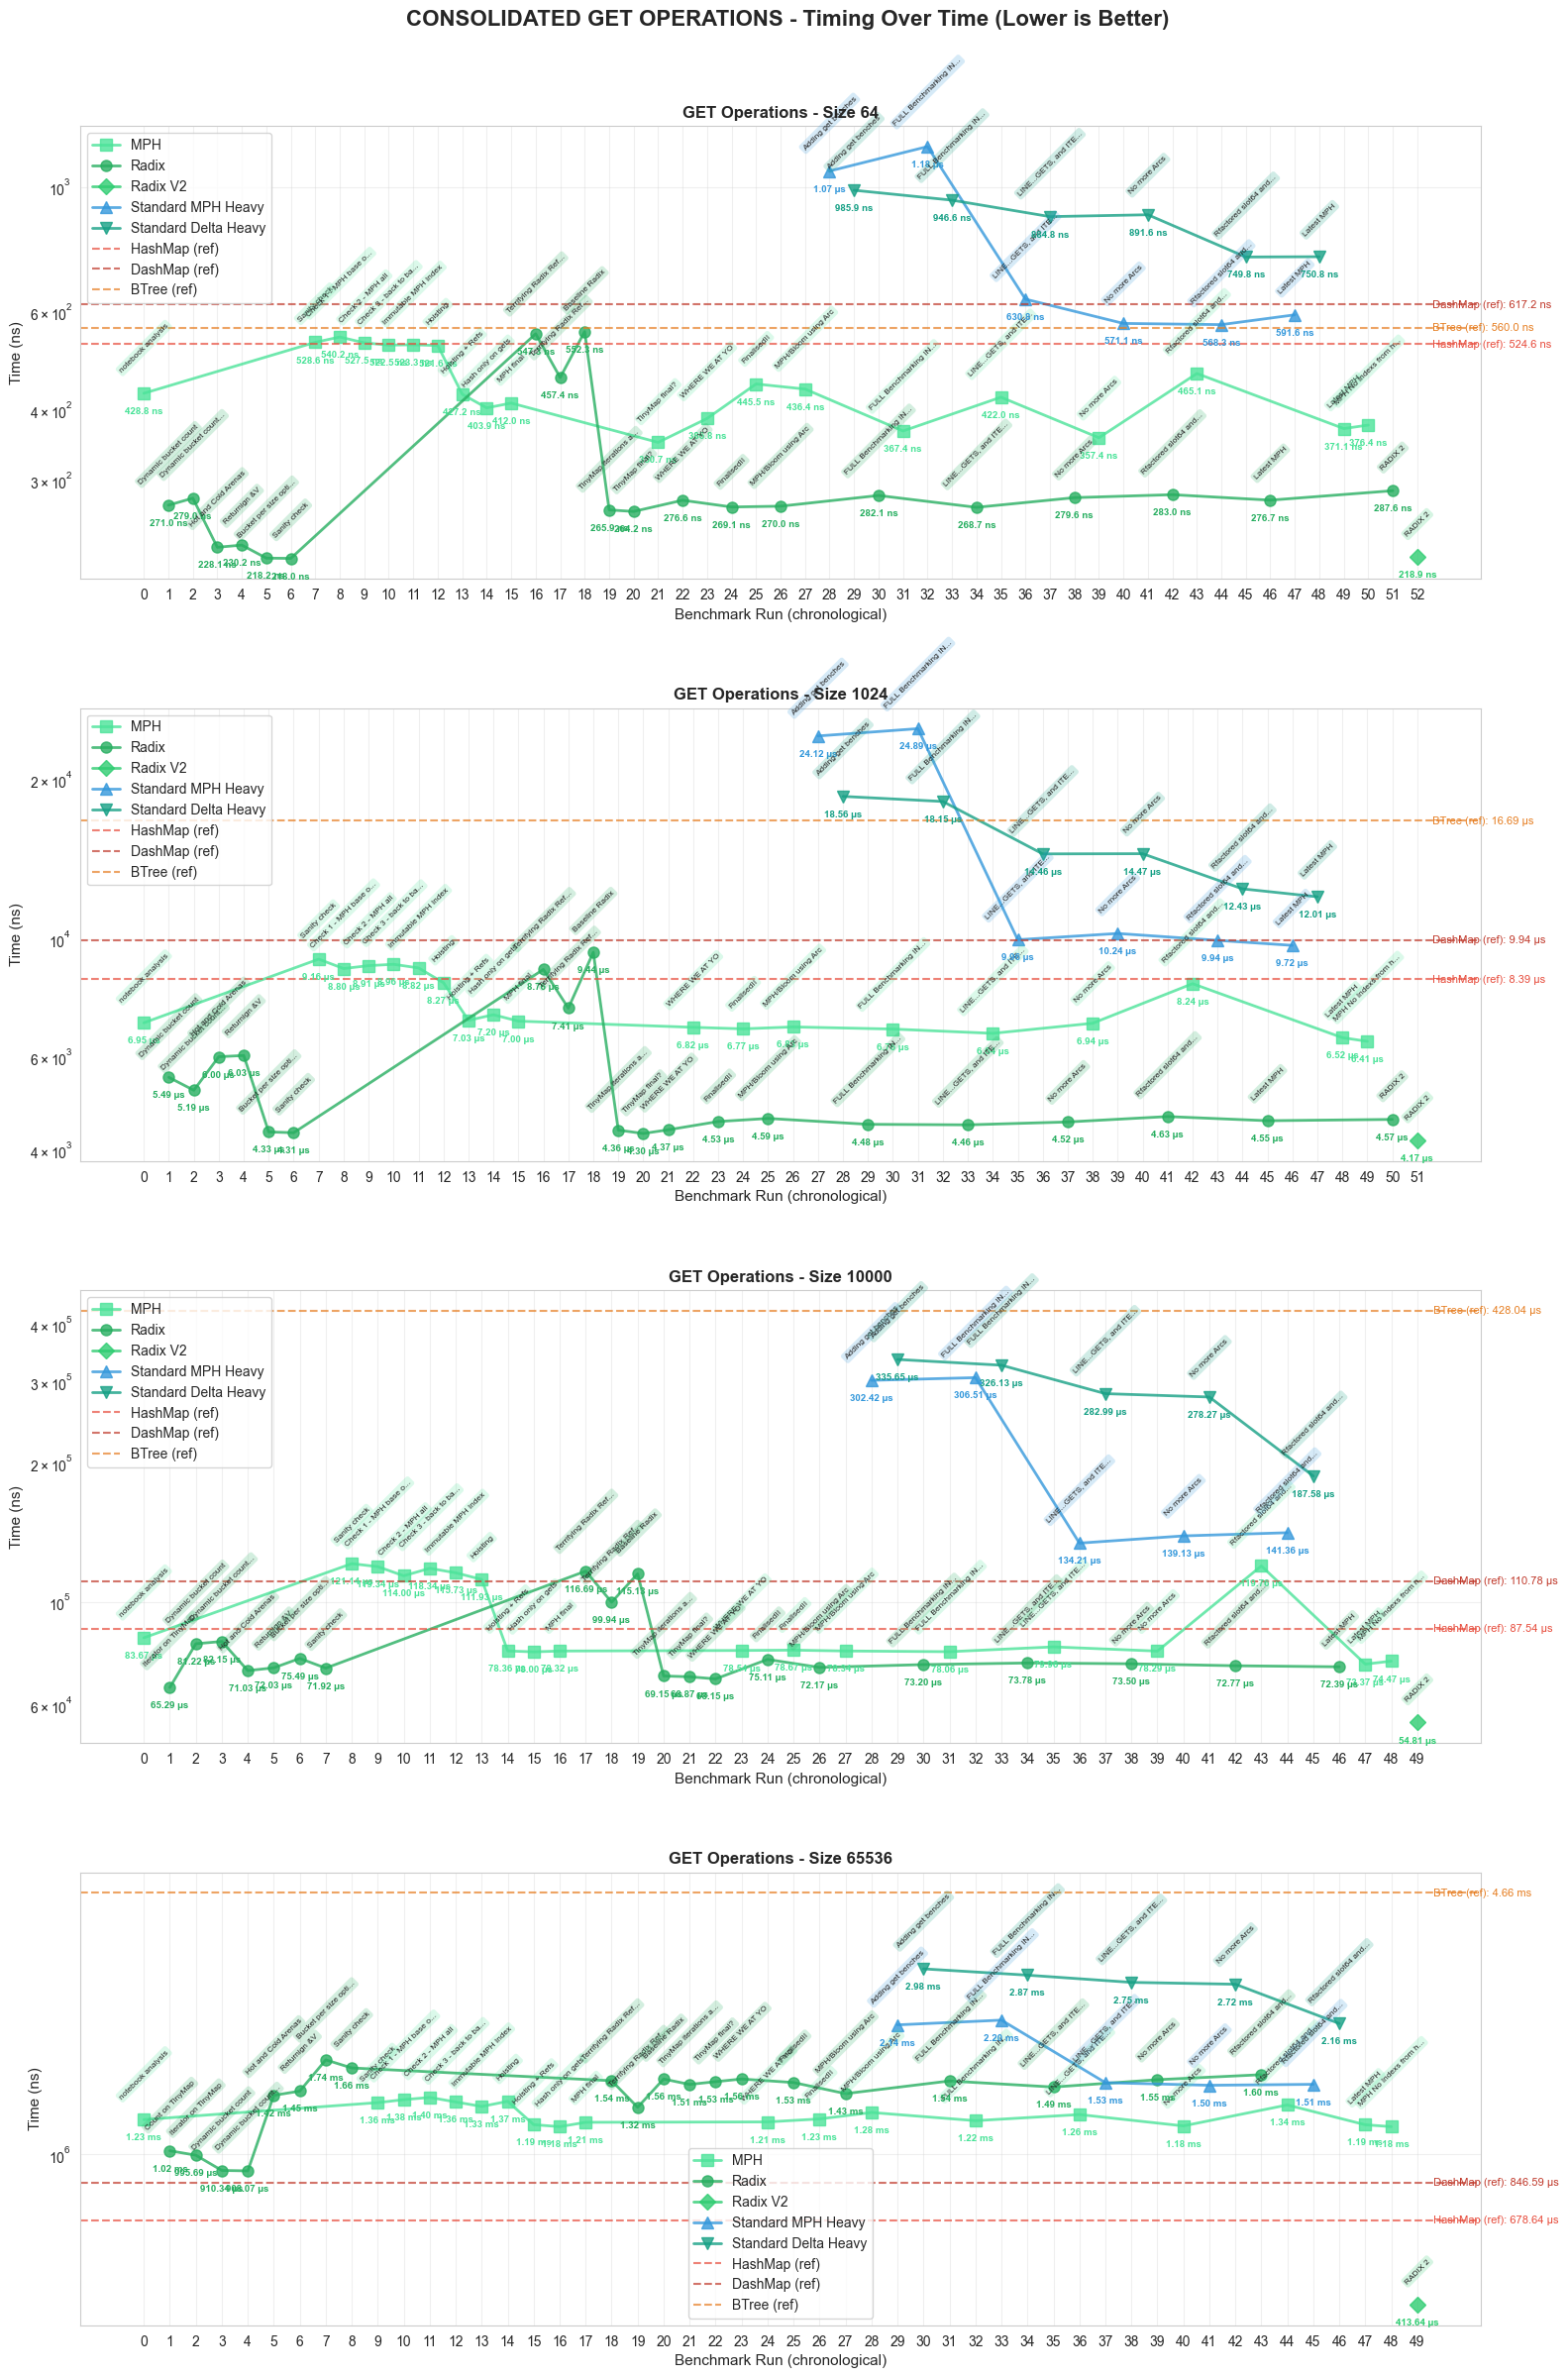

In [35]:
# ============================================================================
# CONSOLIDATED INDEX PERFORMANCE - GET OPERATIONS - TIMING (Lower is Better)
# ============================================================================

# Define colors and labels for each index type
index_config = {
    'optidx_mph_get': {'color': '#4be399', 'label': 'MPH', 'marker': 's'},
    'optidx_radix_get': {'color': '#27ae60', 'label': 'Radix', 'marker': 'o'},
    'radix_v2_get': {'color': '#2ecc71', 'label': 'Radix V2', 'marker': 'D'},
    'optidx_standard_mph_heavy_get': {'color': '#3498db', 'label': 'Standard MPH Heavy', 'marker': '^'},
    'optidx_standard_delta_heavy_get': {'color': '#16a085', 'label': 'Standard Delta Heavy', 'marker': 'v'}
}

# Baseline reference colors (dashed lines)
baseline_config = {
    'hashmap_get': {'color': '#e74c3c', 'label': 'HashMap (ref)', 'linestyle': '--'},
    'dashmap_get': {'color': '#c0392b', 'label': 'DashMap (ref)', 'linestyle': '--'},
    'btree_get': {'color': '#e67e22', 'label': 'BTree (ref)', 'linestyle': '--'}
}

# Collect all GET data
all_get_data = pd.concat([
    df_mph_get_limited,
    df_radix_get_limited,
    df_radix_v2_get_limited,
    df_standard_mph_get_limited,
    df_standard_delta_get_limited
])

# Get unique sizes
sizes = sorted(all_get_data['size'].unique())
num_sizes = len(sizes)

print(f"Creating consolidated timing chart for {num_sizes} sizes: {sizes}")

# Create figure
fig, axes = plt.subplots(num_sizes, 1, figsize=(16, 6 * num_sizes))
fig.suptitle('CONSOLIDATED GET OPERATIONS - Timing Over Time (Lower is Better)', 
             fontsize=16, fontweight='bold', y=0.998)

# Ensure axes is iterable even with single size
if num_sizes == 1:
    axes = [axes]

# Plot each size
for size_idx, size in enumerate(sizes):
    ax = axes[size_idx]
    
    # Get all data for this size and create unified timeline
    size_data = all_get_data[all_get_data['size'] == size].copy()
    unified_timeline = sorted(size_data['timestamp'].unique())
    timestamp_to_index = {ts: idx for idx, ts in enumerate(unified_timeline)}
    
    # Plot each index type
    for operation, config in index_config.items():
        # Filter data for this operation and size
        data = size_data[size_data['operation'] == operation].sort_values('timestamp')
        
        if len(data) > 0:
            # Map timestamps to sequential indices
            x_indices = [timestamp_to_index[ts] for ts in data['timestamp']]
            
            # Plot with sequential indices
            ax.plot(x_indices, data['median_ns'], 
                   marker=config['marker'], linewidth=2, markersize=8,
                   color=config['color'], label=config['label'],
                   alpha=0.8)
            
            # Add value and tag labels at each point
            for x_idx, val, tag in zip(x_indices, data['median_ns'], data['tag']):
                # Add value label (closer to point)
                ax.annotate(format_time_human(val), (x_idx, val), 
                           textcoords="offset points", xytext=(0, -15),
                           ha='center', fontsize=7, fontweight='bold',
                           color=config['color'])
                
                # Add tag label (further from point)
                tag_short = tag[:20] + '...' if len(tag) > 20 else tag
                ax.annotate(tag_short, (x_idx, val), 
                           textcoords="offset points", xytext=(0, 15),
                           ha='center', fontsize=6, rotation=45,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=config['color'], 
                                    alpha=0.2, edgecolor='none'))
    
    # Add baseline reference lines (latest values only)
    for baseline_op, baseline_cfg in baseline_config.items():
        baseline_data = df_get_latest[
            (df_get_latest['operation'] == baseline_op) & 
            (df_get_latest['size'] == size)
        ]
        if len(baseline_data) > 0:
            baseline_val = baseline_data['median_ns'].values[0]
            ax.axhline(y=baseline_val, color=baseline_cfg['color'], 
                      linestyle=baseline_cfg['linestyle'], linewidth=1.5,
                      label=baseline_cfg['label'], alpha=0.7)
            # Add label at the right edge
            ax.text(len(unified_timeline) - 0.5, baseline_val, 
                   f" {baseline_cfg['label']}: {format_time_human(baseline_val)}",
                   va='center', fontsize=8, color=baseline_cfg['color'])
    
    # Customize
    ax.set_xlabel('Benchmark Run (chronological)', fontsize=11)
    ax.set_ylabel('Time (ns)', fontsize=11)
    ax.set_title(f'GET Operations - Size {size}', fontsize=12, fontweight='bold')
    ax.set_yscale(Y_SCALE)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.set_xticks(range(len(unified_timeline)))
    ax.set_xticklabels([f'{i}' for i in range(len(unified_timeline))], rotation=0)

plt.tight_layout()
plt.show()



Creating consolidated throughput chart for 4 sizes: [np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]


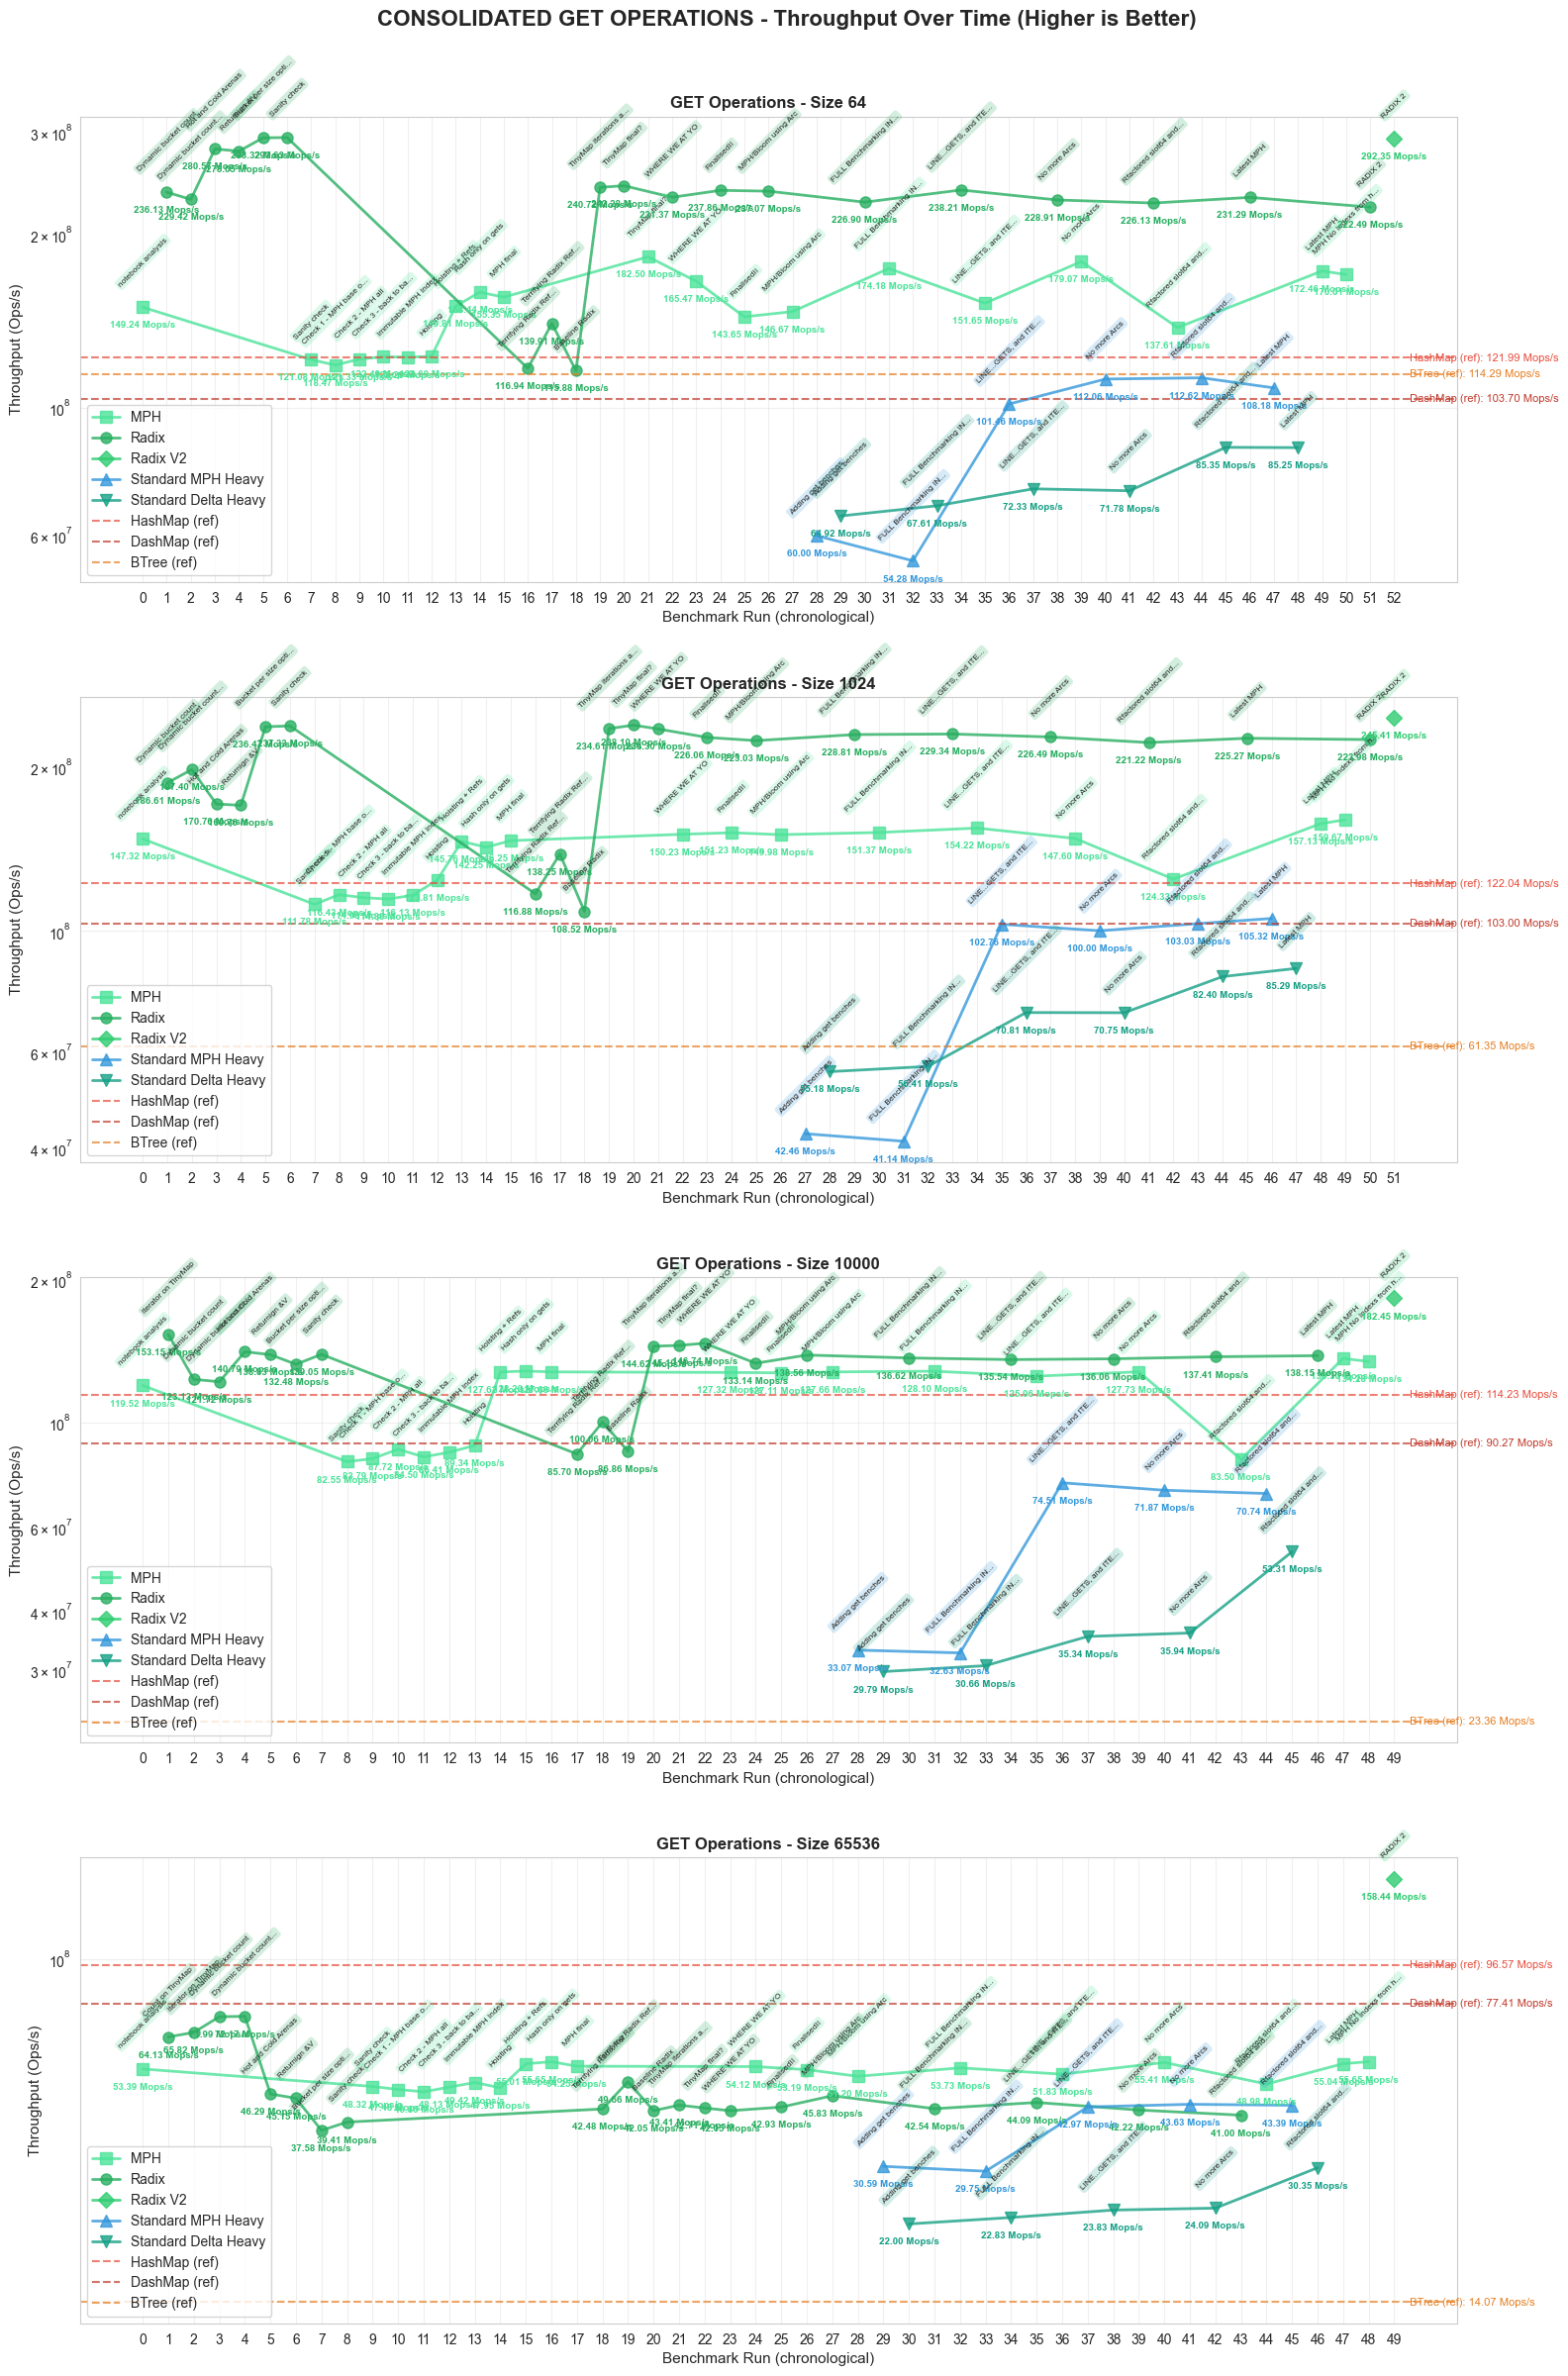

In [36]:
# ============================================================================
# CONSOLIDATED INDEX PERFORMANCE - GET OPERATIONS - THROUGHPUT (Higher is Better)
# ============================================================================

# Use same configs from previous cell
# Collect all GET data
all_get_data = pd.concat([
    df_mph_get_limited,
    df_radix_get_limited,
    df_radix_v2_get_limited,
    df_standard_mph_get_limited,
    df_standard_delta_get_limited
])

# Get unique sizes
sizes = sorted(all_get_data['size'].unique())
num_sizes = len(sizes)

print(f"Creating consolidated throughput chart for {num_sizes} sizes: {sizes}")

# Create figure
fig, axes = plt.subplots(num_sizes, 1, figsize=(16, 6 * num_sizes))
fig.suptitle('CONSOLIDATED GET OPERATIONS - Throughput Over Time (Higher is Better)', 
             fontsize=16, fontweight='bold', y=0.998)

# Ensure axes is iterable even with single size
if num_sizes == 1:
    axes = [axes]

# Plot each size
for size_idx, size in enumerate(sizes):
    ax = axes[size_idx]
    
    # Get all data for this size and create unified timeline
    size_data = all_get_data[all_get_data['size'] == size].copy()
    unified_timeline = sorted(size_data['timestamp'].unique())
    timestamp_to_index = {ts: idx for idx, ts in enumerate(unified_timeline)}
    
    # Plot each index type
    for operation, config in index_config.items():
        # Filter data for this operation and size
        data = size_data[size_data['operation'] == operation].sort_values('timestamp')
        
        if len(data) > 0:
            # Map timestamps to sequential indices
            x_indices = [timestamp_to_index[ts] for ts in data['timestamp']]
            
            # Plot with sequential indices
            ax.plot(x_indices, data['throughput_ops_sec'], 
                   marker=config['marker'], linewidth=2, markersize=8,
                   color=config['color'], label=config['label'],
                   alpha=0.8)
            
            # Add value and tag labels at each point
            for x_idx, val, pretty, tag in zip(x_indices, data['throughput_ops_sec'], 
                                                data['throughput_pretty'], data['tag']):
                # Add value label (closer to point)
                ax.annotate(pretty, (x_idx, val), 
                           textcoords="offset points", xytext=(0, -15),
                           ha='center', fontsize=7, fontweight='bold',
                           color=config['color'])
                
                # Add tag label (further from point)
                tag_short = tag[:20] + '...' if len(tag) > 20 else tag
                ax.annotate(tag_short, (x_idx, val), 
                           textcoords="offset points", xytext=(0, 15),
                           ha='center', fontsize=6, rotation=45,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=config['color'], 
                                    alpha=0.2, edgecolor='none'))
    
    # Add baseline reference lines (latest values only)
    for baseline_op, baseline_cfg in baseline_config.items():
        baseline_data = df_get_latest[
            (df_get_latest['operation'] == baseline_op) & 
            (df_get_latest['size'] == size)
        ]
        if len(baseline_data) > 0:
            baseline_val = baseline_data['throughput_ops_sec'].values[0]
            baseline_pretty = baseline_data['throughput_pretty'].values[0]
            ax.axhline(y=baseline_val, color=baseline_cfg['color'], 
                      linestyle=baseline_cfg['linestyle'], linewidth=1.5,
                      label=baseline_cfg['label'], alpha=0.7)
            # Add label at the right edge
            ax.text(len(unified_timeline) - 0.5, baseline_val, 
                   f" {baseline_cfg['label']}: {baseline_pretty}",
                   va='center', fontsize=8, color=baseline_cfg['color'])
    
    # Customize
    ax.set_xlabel('Benchmark Run (chronological)', fontsize=11)
    ax.set_ylabel('Throughput (Ops/s)', fontsize=11)
    ax.set_title(f'GET Operations - Size {size}', fontsize=12, fontweight='bold')
    ax.set_yscale(Y_SCALE)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.set_xticks(range(len(unified_timeline)))
    ax.set_xticklabels([f'{i}' for i in range(len(unified_timeline))], rotation=0)

plt.tight_layout()
plt.show()


Creating consolidated ITER timing chart for 4 sizes: [np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]


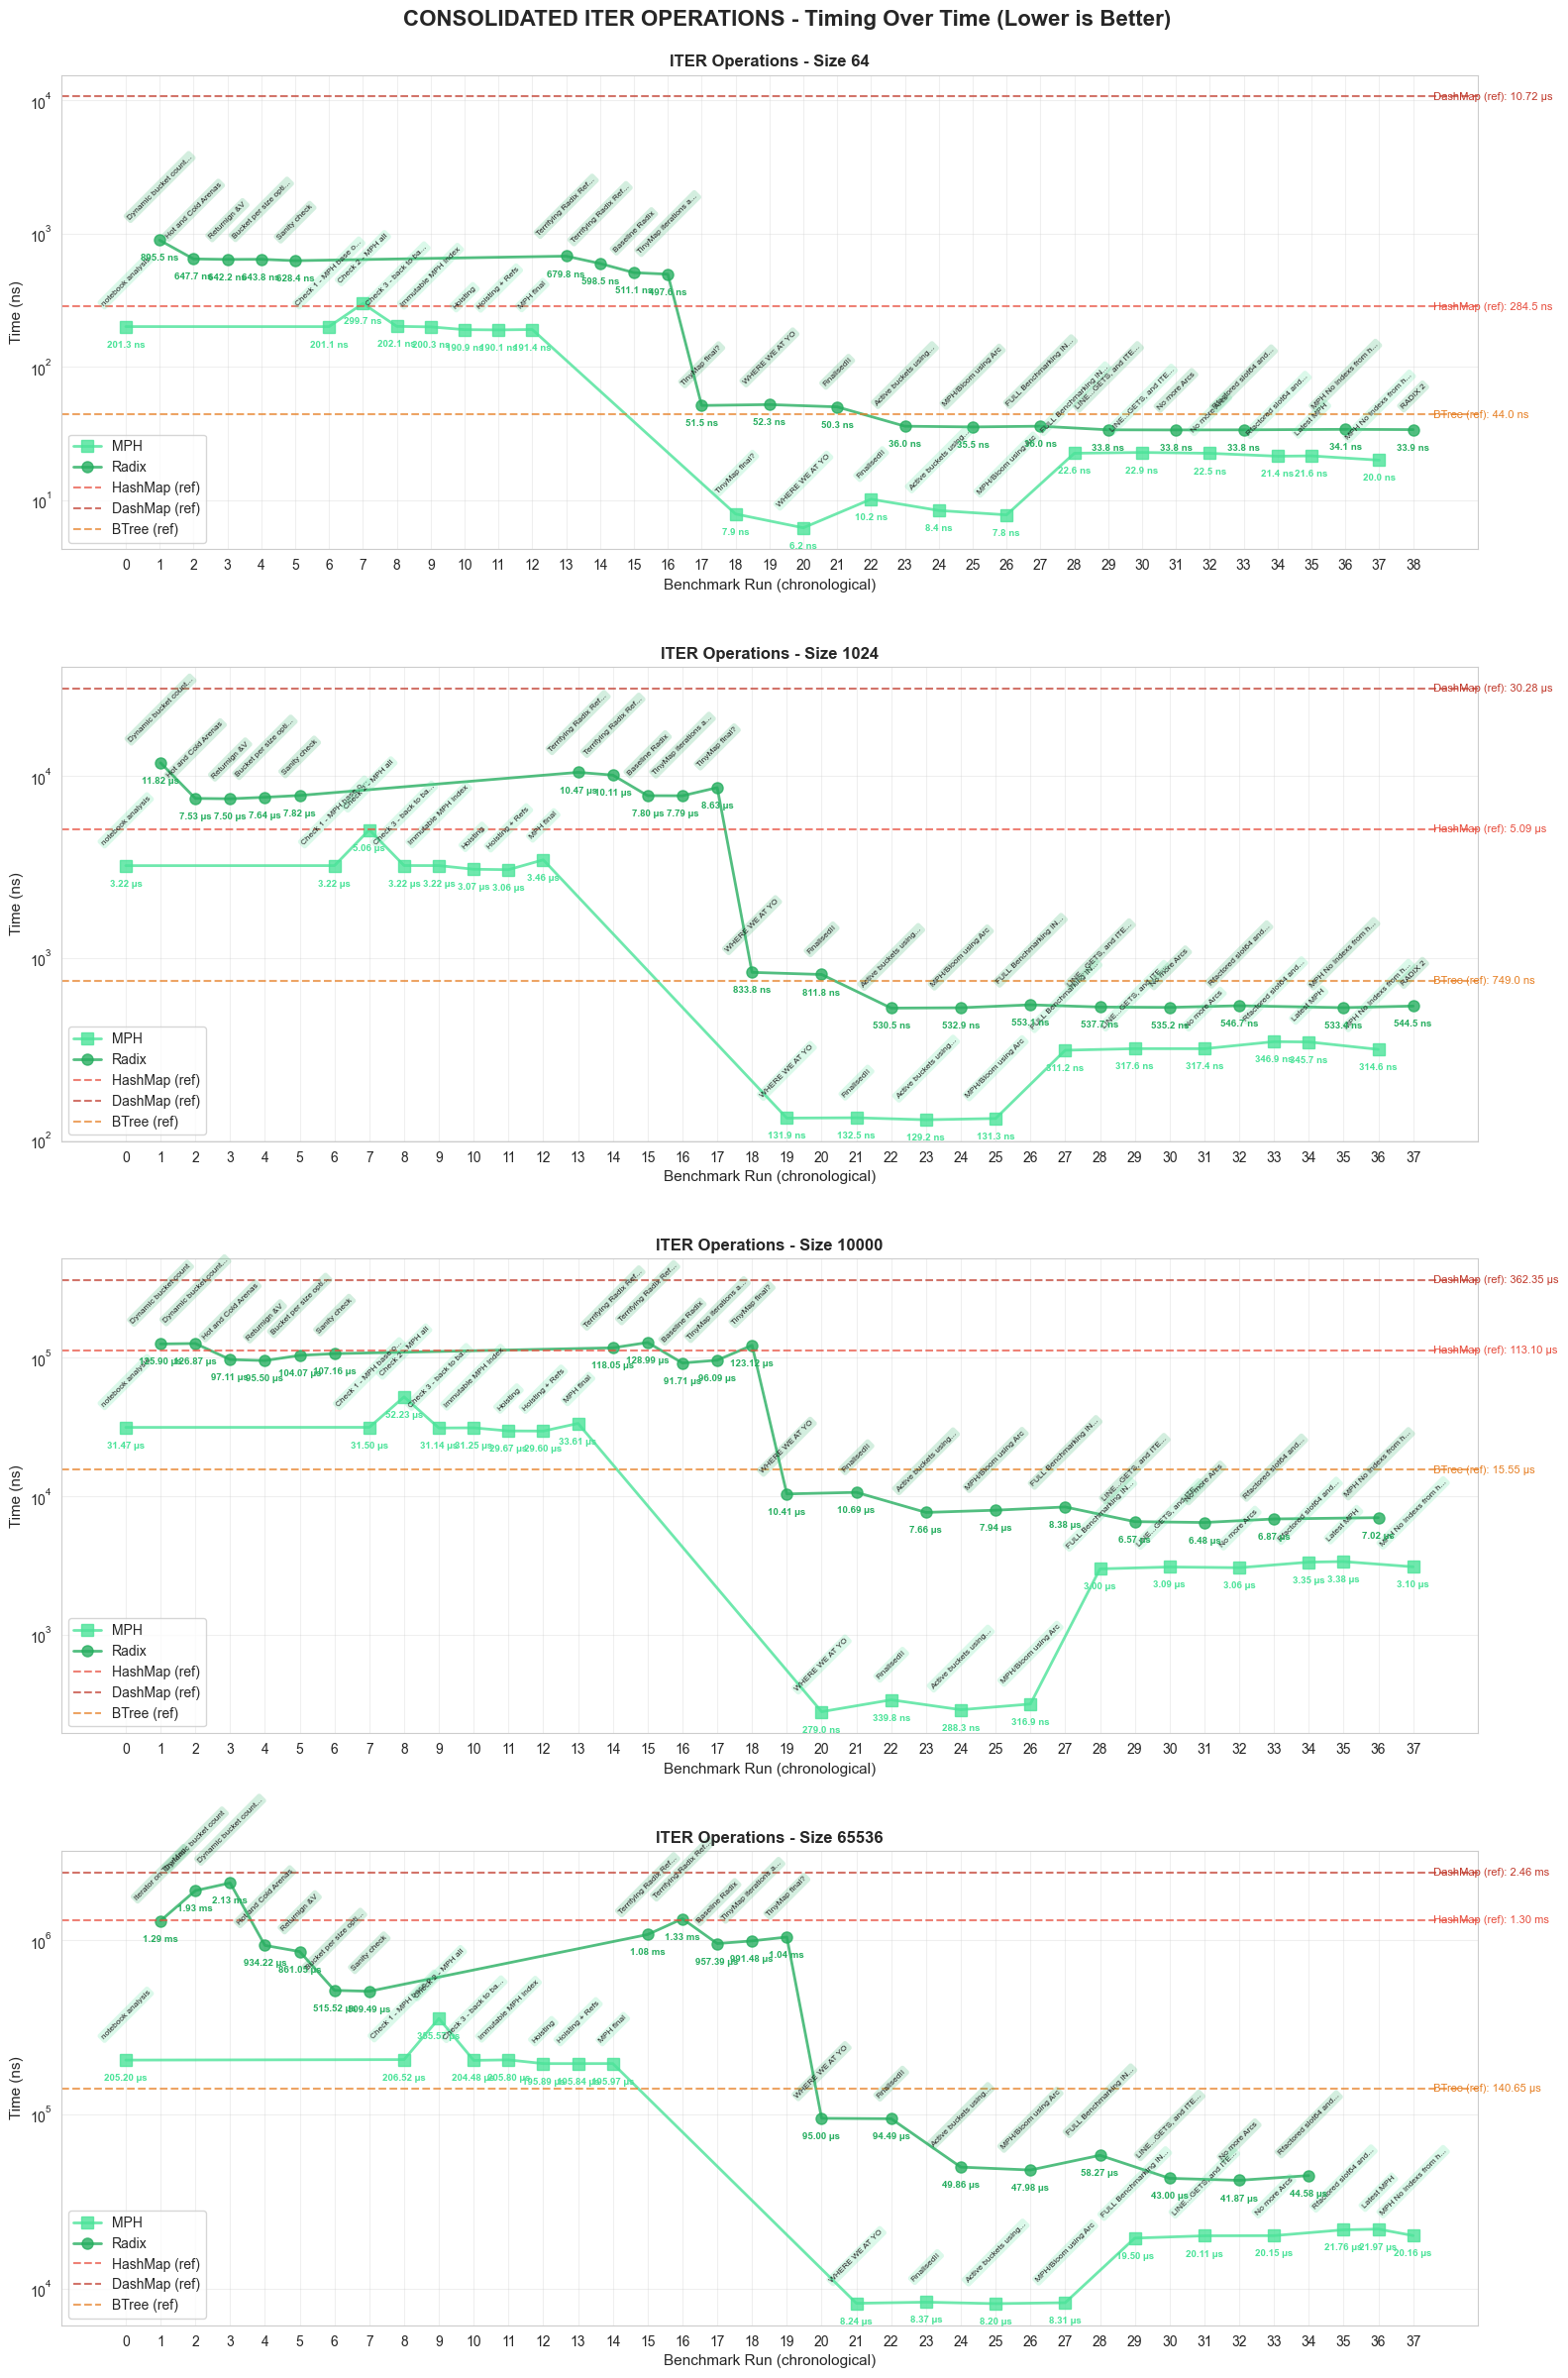

In [37]:
# ============================================================================
# CONSOLIDATED INDEX PERFORMANCE - ITER OPERATIONS - TIMING (Lower is Better)
# ============================================================================

# Define colors and labels for each index type (ITER operations)
iter_index_config = {
    'optidx_mph_iter_all': {'color': '#4be399', 'label': 'MPH', 'marker': 's'},
    'optidx_radix_iter_all': {'color': '#27ae60', 'label': 'Radix', 'marker': 'o'},
    'optidx_standard_mph_heavy_iter_all': {'color': '#3498db', 'label': 'Standard MPH Heavy', 'marker': '^'},
    'optidx_standard_delta_heavy_iter_all': {'color': '#16a085', 'label': 'Standard Delta Heavy', 'marker': 'v'}
}

# Baseline reference colors (dashed lines)
iter_baseline_config = {
    'hashmap_iter_all': {'color': '#e74c3c', 'label': 'HashMap (ref)', 'linestyle': '--'},
    'dashmap_iter_all': {'color': '#c0392b', 'label': 'DashMap (ref)', 'linestyle': '--'},
    'btree_iter_all': {'color': '#e67e22', 'label': 'BTree (ref)', 'linestyle': '--'}
}

# Collect all ITER data
all_iter_data = pd.concat([
    df_mph_iter_limited,
    df_radix_iter_limited,
    df_standard_mph_iter_limited,
    df_standard_delta_iter_limited
])

# Get unique sizes
iter_sizes = sorted(all_iter_data['size'].unique()) if len(all_iter_data) > 0 else []
num_iter_sizes = len(iter_sizes)

if num_iter_sizes > 0:
    print(f"Creating consolidated ITER timing chart for {num_iter_sizes} sizes: {iter_sizes}")
    
    # Create figure
    fig, axes = plt.subplots(num_iter_sizes, 1, figsize=(16, 6 * num_iter_sizes))
    fig.suptitle('CONSOLIDATED ITER OPERATIONS - Timing Over Time (Lower is Better)', 
                 fontsize=16, fontweight='bold', y=0.998)
    
    # Ensure axes is iterable even with single size
    if num_iter_sizes == 1:
        axes = [axes]
    
    # Plot each size
    for size_idx, size in enumerate(iter_sizes):
        ax = axes[size_idx]
        
        # Get all data for this size and create unified timeline
        size_data = all_iter_data[all_iter_data['size'] == size].copy()
        unified_timeline = sorted(size_data['timestamp'].unique())
        timestamp_to_index = {ts: idx for idx, ts in enumerate(unified_timeline)}
        
        # Plot each index type
        for operation, config in iter_index_config.items():
            # Filter data for this operation and size
            data = size_data[size_data['operation'] == operation].sort_values('timestamp')
            
            if len(data) > 0:
                # Map timestamps to sequential indices
                x_indices = [timestamp_to_index[ts] for ts in data['timestamp']]
                
                # Plot with sequential indices
                ax.plot(x_indices, data['median_ns'], 
                       marker=config['marker'], linewidth=2, markersize=8,
                       color=config['color'], label=config['label'],
                       alpha=0.8)
                
                # Add value and tag labels at each point
                for x_idx, val, tag in zip(x_indices, data['median_ns'], data['tag']):
                    # Add value label (closer to point)
                    ax.annotate(format_time_human(val), (x_idx, val), 
                               textcoords="offset points", xytext=(0, -15),
                               ha='center', fontsize=7, fontweight='bold',
                               color=config['color'])
                    
                    # Add tag label (further from point)
                    tag_short = tag[:20] + '...' if len(tag) > 20 else tag
                    ax.annotate(tag_short, (x_idx, val), 
                               textcoords="offset points", xytext=(0, 15),
                               ha='center', fontsize=6, rotation=45,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor=config['color'], 
                                        alpha=0.2, edgecolor='none'))
        
        # Add baseline reference lines (latest values only)
        for baseline_op, baseline_cfg in iter_baseline_config.items():
            baseline_data = df_iter_latest[
                (df_iter_latest['operation'] == baseline_op) & 
                (df_iter_latest['size'] == size)
            ]
            if len(baseline_data) > 0:
                baseline_val = baseline_data['median_ns'].values[0]
                ax.axhline(y=baseline_val, color=baseline_cfg['color'], 
                          linestyle=baseline_cfg['linestyle'], linewidth=1.5,
                          label=baseline_cfg['label'], alpha=0.7)
                # Add label at the right edge
                ax.text(len(unified_timeline) - 0.5, baseline_val, 
                       f" {baseline_cfg['label']}: {format_time_human(baseline_val)}",
                       va='center', fontsize=8, color=baseline_cfg['color'])
        
        # Customize
        ax.set_xlabel('Benchmark Run (chronological)', fontsize=11)
        ax.set_ylabel('Time (ns)', fontsize=11)
        ax.set_title(f'ITER Operations - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.set_xticks(range(len(unified_timeline)))
        ax.set_xticklabels([f'{i}' for i in range(len(unified_timeline))], rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("No ITER data available yet for the new index types")


Creating consolidated ITER throughput chart for 4 sizes: [np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]


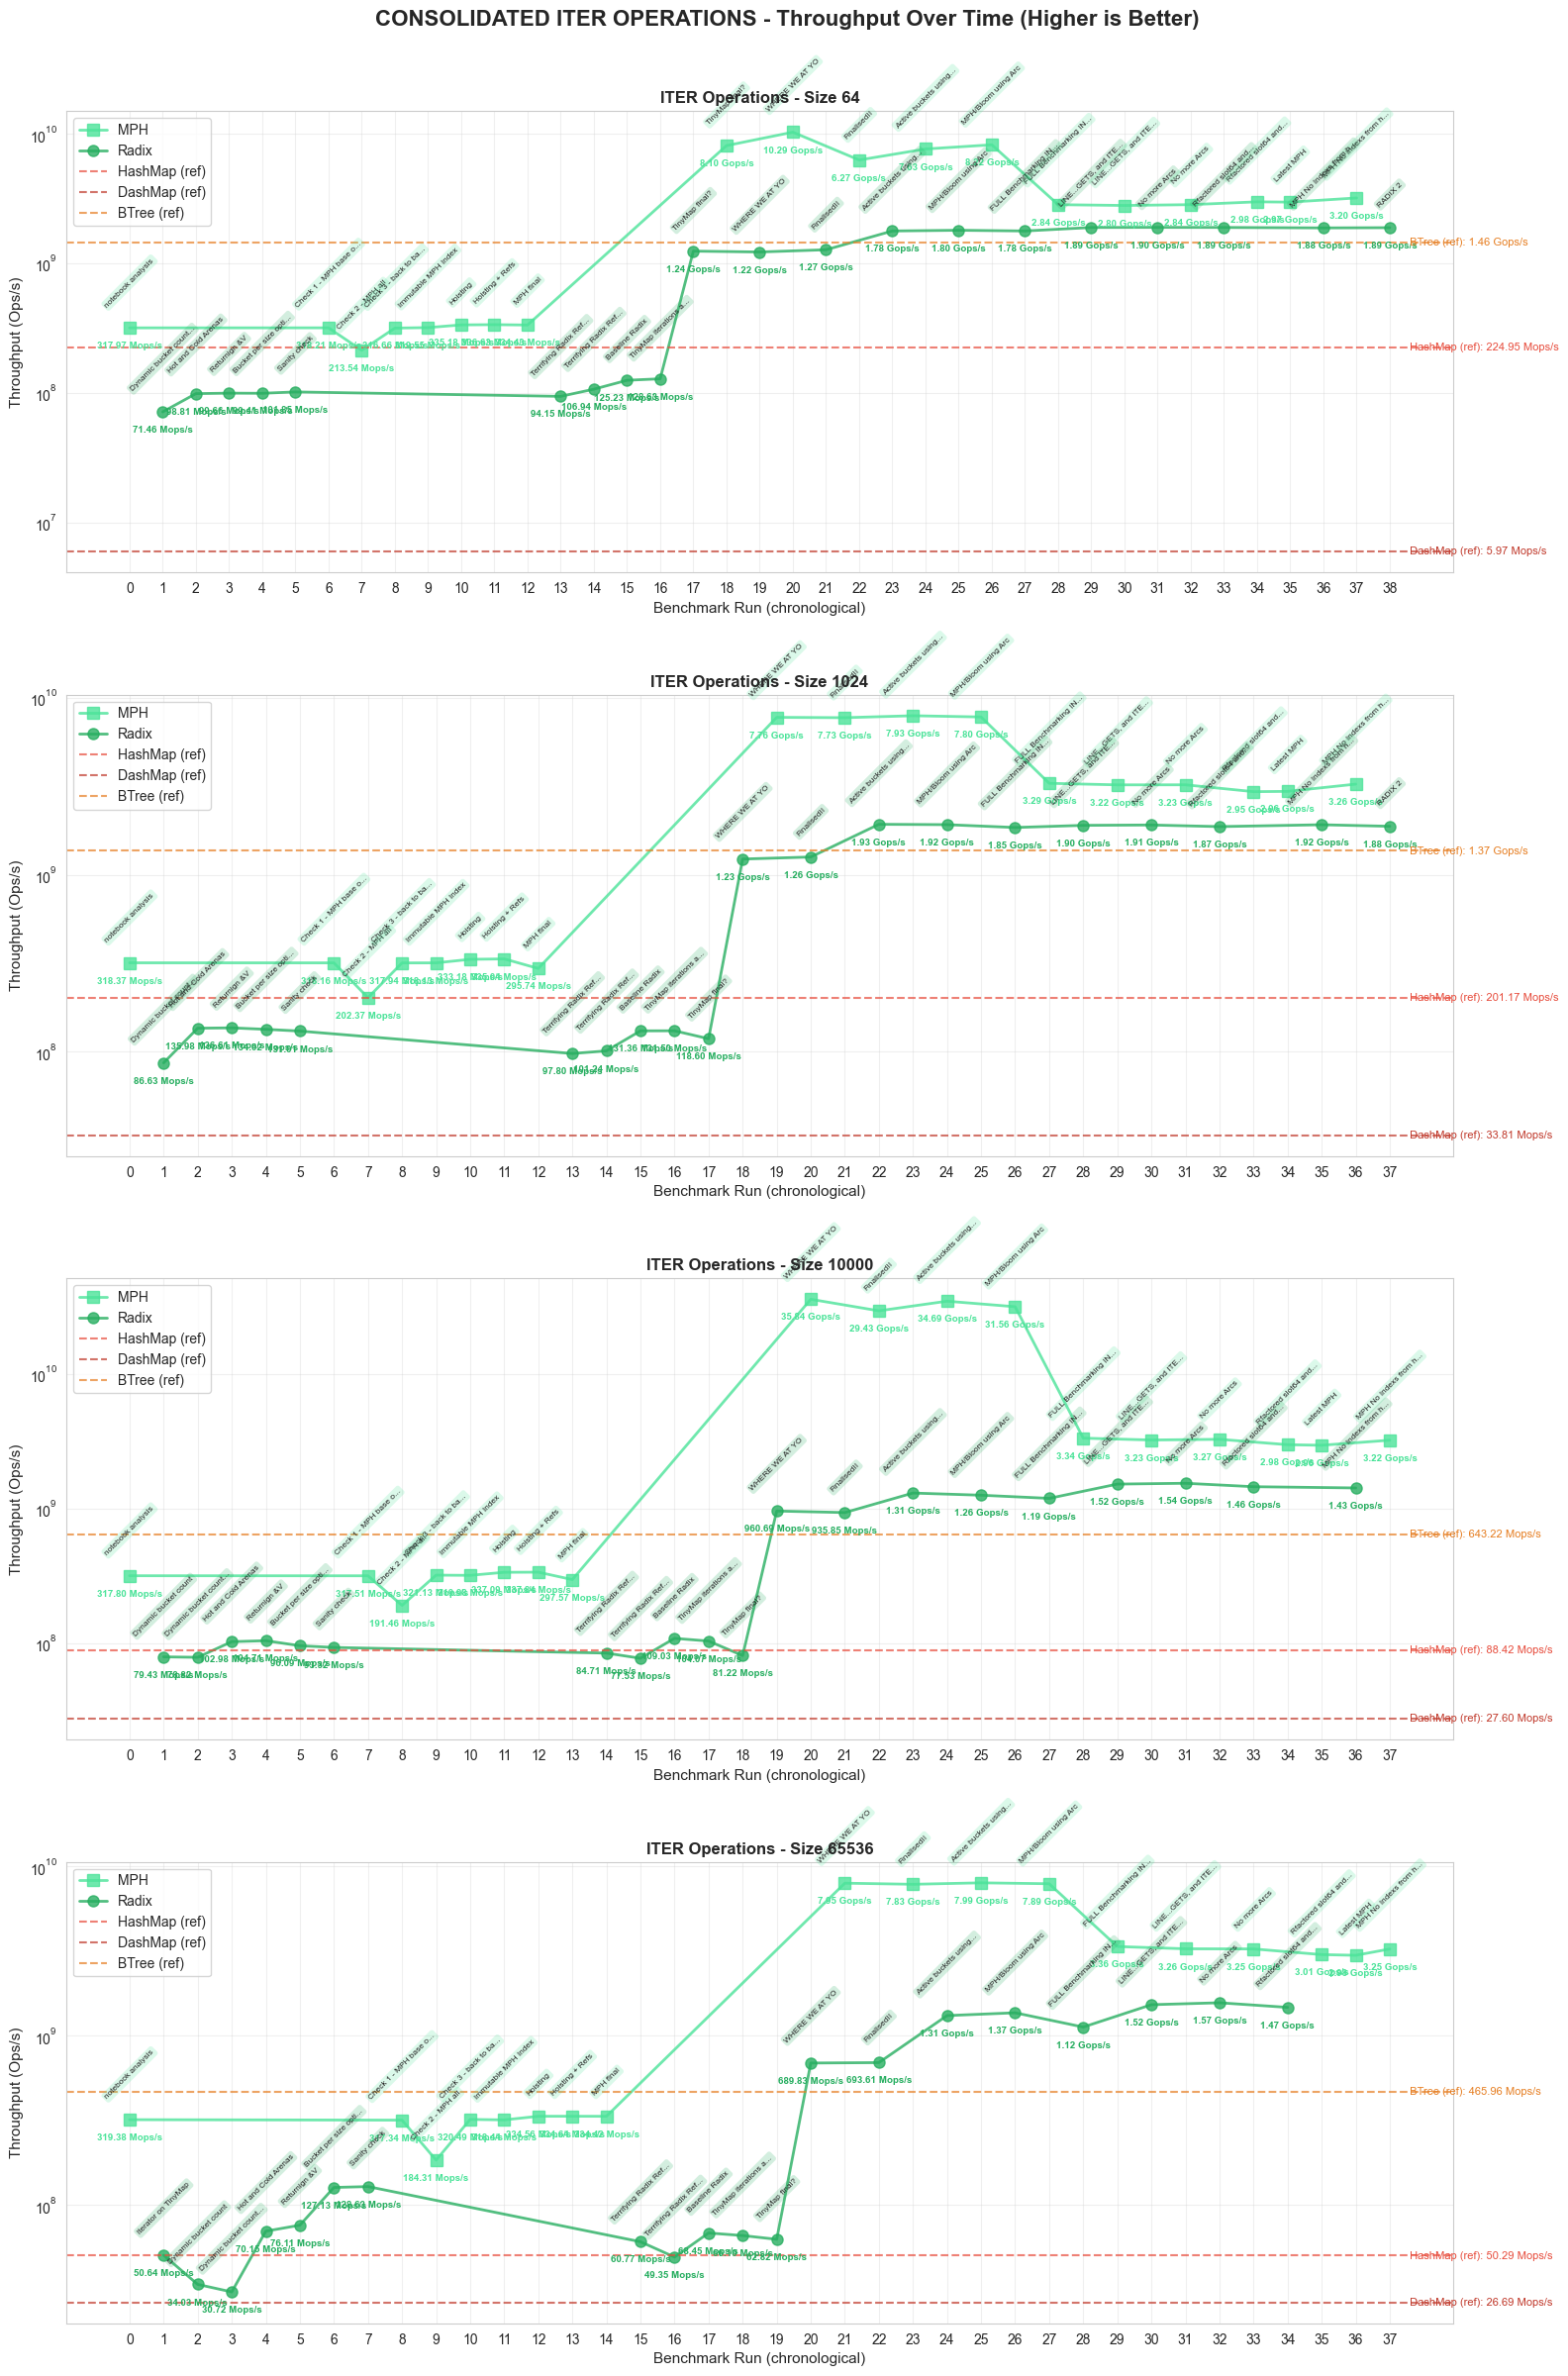

In [38]:
# ============================================================================
# CONSOLIDATED INDEX PERFORMANCE - ITER OPERATIONS - THROUGHPUT (Higher is Better)
# ============================================================================

# Collect all ITER data
all_iter_data = pd.concat([
    df_mph_iter_limited,
    df_radix_iter_limited,
    df_standard_mph_iter_limited,
    df_standard_delta_iter_limited
])

# Get unique sizes
iter_sizes = sorted(all_iter_data['size'].unique()) if len(all_iter_data) > 0 else []
num_iter_sizes = len(iter_sizes)

if num_iter_sizes > 0:
    print(f"Creating consolidated ITER throughput chart for {num_iter_sizes} sizes: {iter_sizes}")
    
    # Create figure
    fig, axes = plt.subplots(num_iter_sizes, 1, figsize=(16, 6 * num_iter_sizes))
    fig.suptitle('CONSOLIDATED ITER OPERATIONS - Throughput Over Time (Higher is Better)', 
                 fontsize=16, fontweight='bold', y=0.998)
    
    # Ensure axes is iterable even with single size
    if num_iter_sizes == 1:
        axes = [axes]
    
    # Plot each size
    for size_idx, size in enumerate(iter_sizes):
        ax = axes[size_idx]
        
        # Get all data for this size and create unified timeline
        size_data = all_iter_data[all_iter_data['size'] == size].copy()
        unified_timeline = sorted(size_data['timestamp'].unique())
        timestamp_to_index = {ts: idx for idx, ts in enumerate(unified_timeline)}
        
        # Plot each index type
        for operation, config in iter_index_config.items():
            # Filter data for this operation and size
            data = size_data[size_data['operation'] == operation].sort_values('timestamp')
            
            if len(data) > 0:
                # Map timestamps to sequential indices
                x_indices = [timestamp_to_index[ts] for ts in data['timestamp']]
                
                # Plot with sequential indices
                ax.plot(x_indices, data['throughput_ops_sec'], 
                       marker=config['marker'], linewidth=2, markersize=8,
                       color=config['color'], label=config['label'],
                       alpha=0.8)
                
                # Add value and tag labels at each point
                for x_idx, val, pretty, tag in zip(x_indices, data['throughput_ops_sec'], 
                                                    data['throughput_pretty'], data['tag']):
                    # Add value label (closer to point)
                    ax.annotate(pretty, (x_idx, val), 
                               textcoords="offset points", xytext=(0, -15),
                               ha='center', fontsize=7, fontweight='bold',
                               color=config['color'])
                    
                    # Add tag label (further from point)
                    tag_short = tag[:20] + '...' if len(tag) > 20 else tag
                    ax.annotate(tag_short, (x_idx, val), 
                               textcoords="offset points", xytext=(0, 15),
                               ha='center', fontsize=6, rotation=45,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor=config['color'], 
                                        alpha=0.2, edgecolor='none'))
        
        # Add baseline reference lines (latest values only)
        for baseline_op, baseline_cfg in iter_baseline_config.items():
            baseline_data = df_iter_latest[
                (df_iter_latest['operation'] == baseline_op) & 
                (df_iter_latest['size'] == size)
            ]
            if len(baseline_data) > 0:
                baseline_val = baseline_data['throughput_ops_sec'].values[0]
                baseline_pretty = baseline_data['throughput_pretty'].values[0]
                ax.axhline(y=baseline_val, color=baseline_cfg['color'], 
                          linestyle=baseline_cfg['linestyle'], linewidth=1.5,
                          label=baseline_cfg['label'], alpha=0.7)
                # Add label at the right edge
                ax.text(len(unified_timeline) - 0.5, baseline_val, 
                       f" {baseline_cfg['label']}: {baseline_pretty}",
                       va='center', fontsize=8, color=baseline_cfg['color'])
        
        # Customize
        ax.set_xlabel('Benchmark Run (chronological)', fontsize=11)
        ax.set_ylabel('Throughput (Ops/s)', fontsize=11)
        ax.set_title(f'ITER Operations - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.set_xticks(range(len(unified_timeline)))
        ax.set_xticklabels([f'{i}' for i in range(len(unified_timeline))], rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("No ITER data available yet for the new index types")


Creating consolidated INSERT timing chart for 4 sizes: [np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]


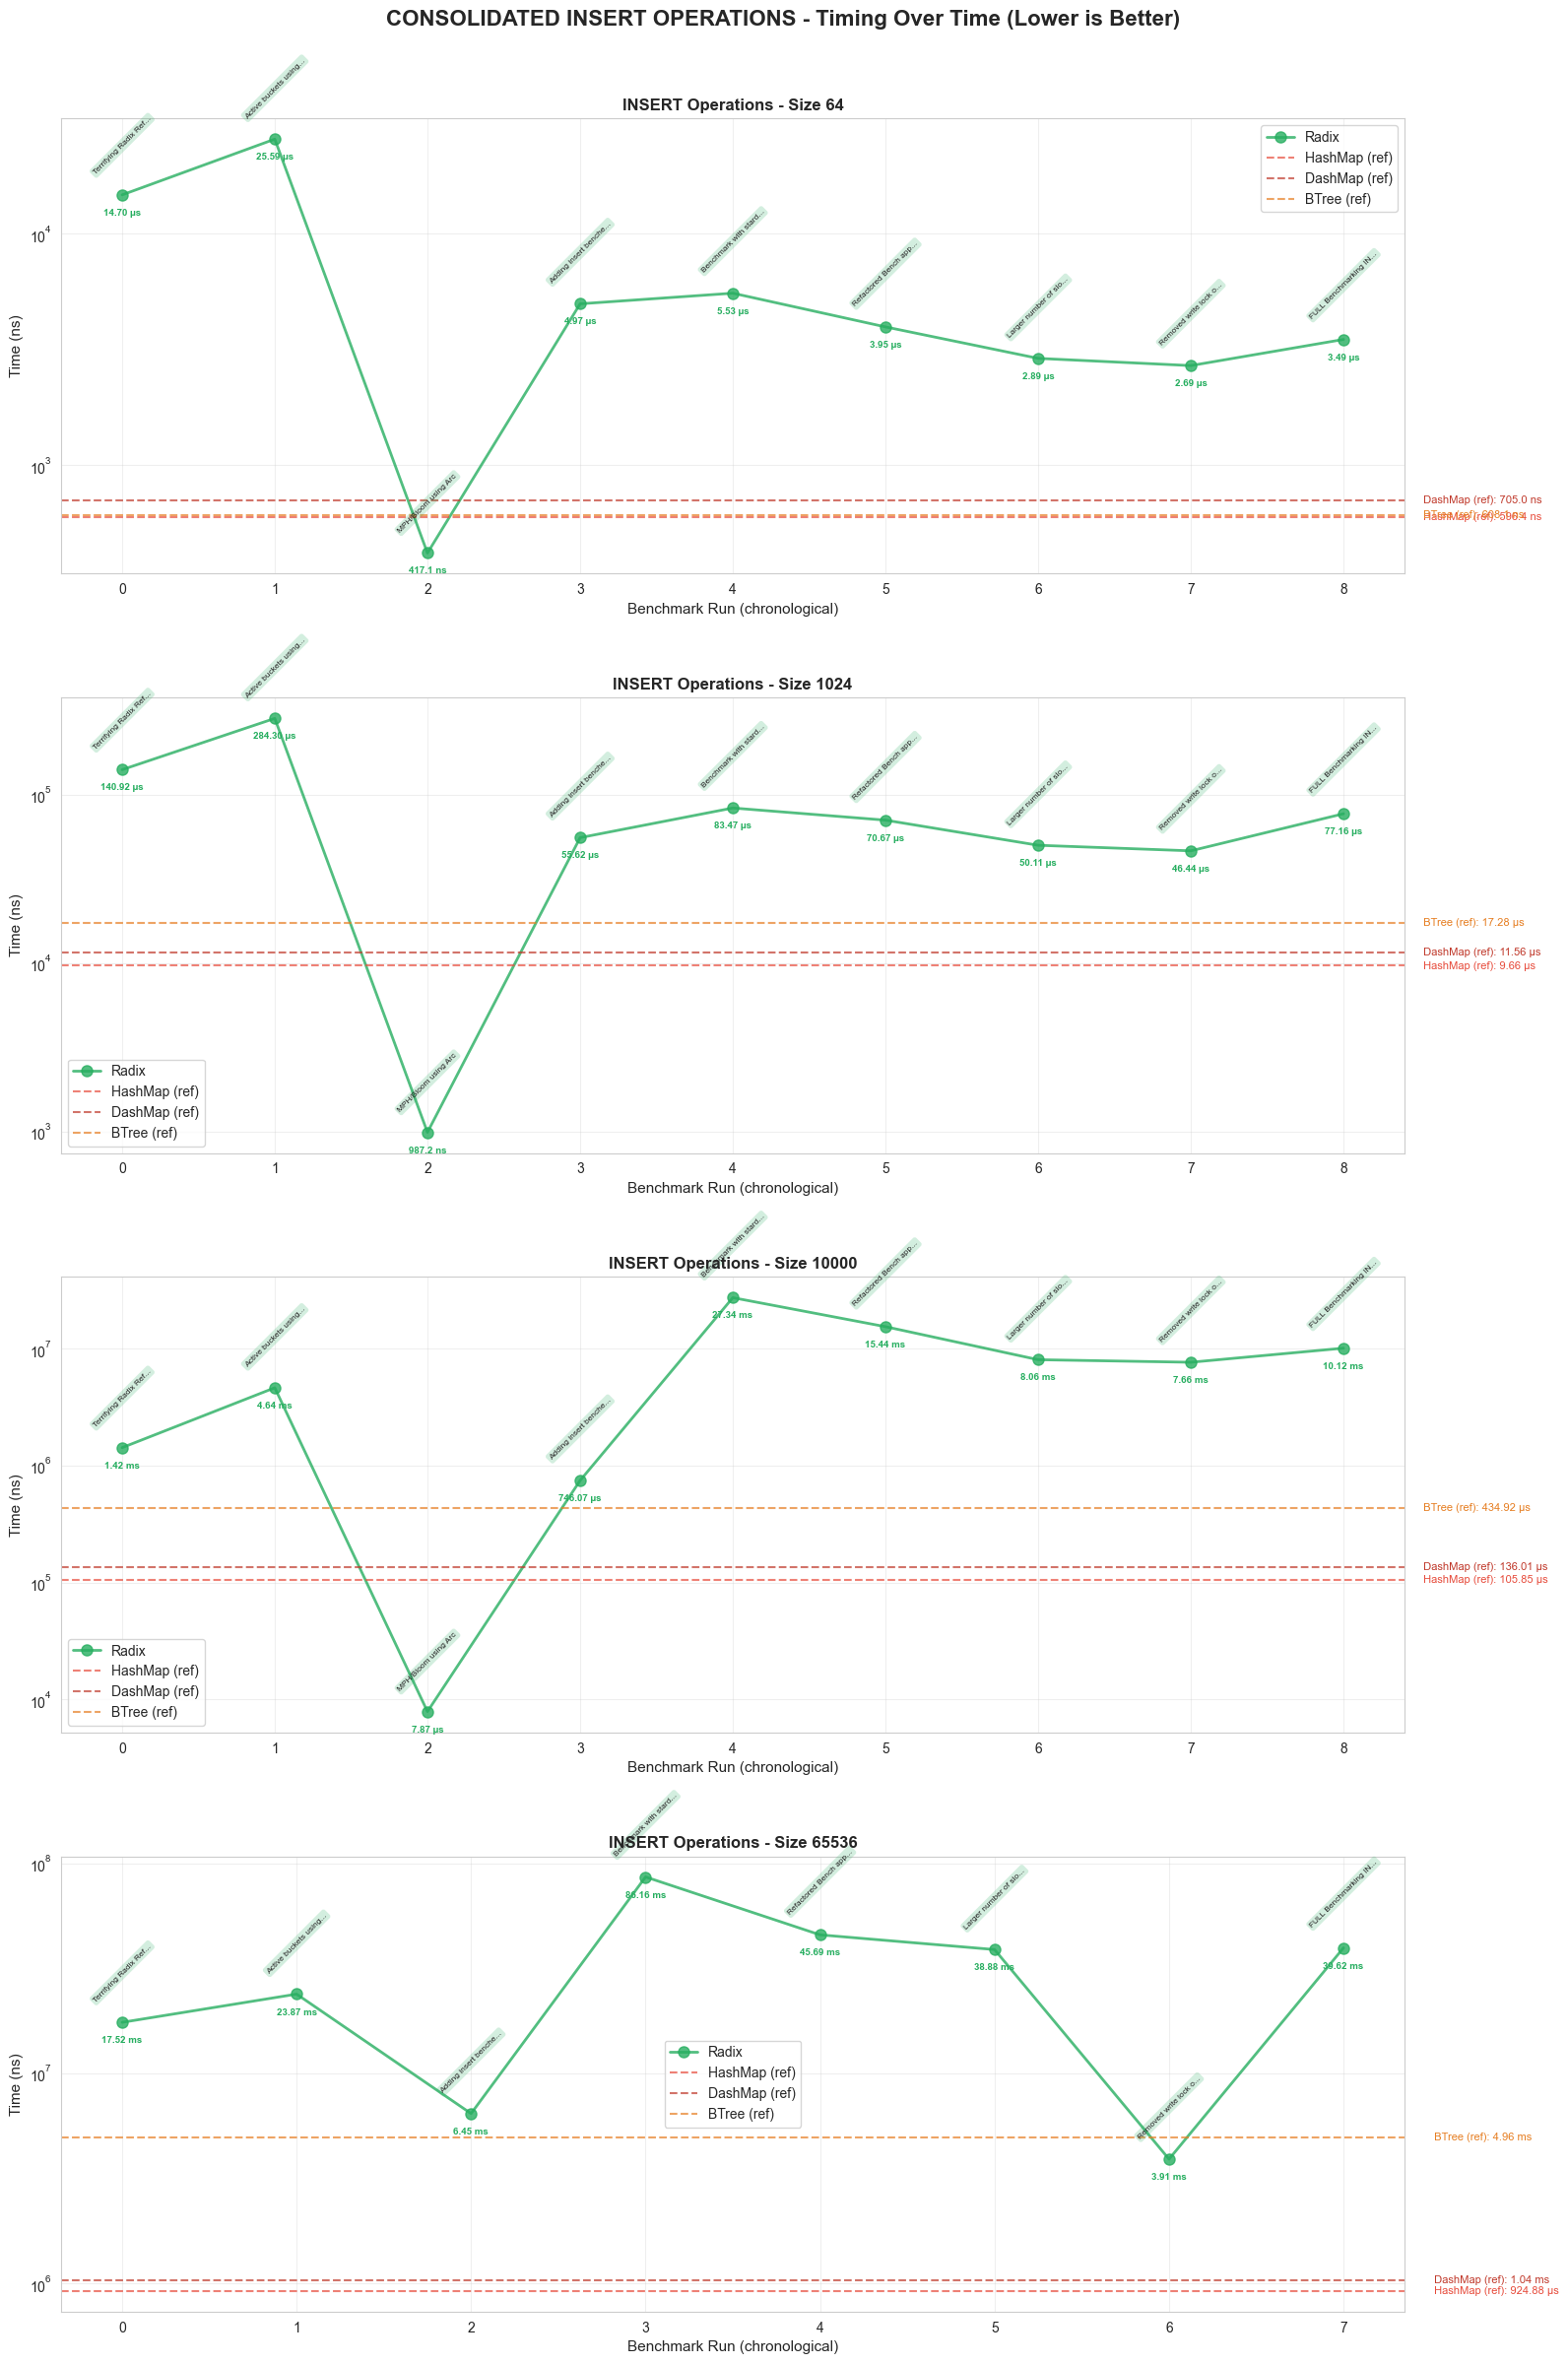

In [39]:
# ============================================================================
# CONSOLIDATED INDEX PERFORMANCE - INSERT OPERATIONS - TIMING (Lower is Better)
# ============================================================================

# Define colors and labels for each index type (INSERT operations)
insert_index_config = {
    'optidx_radix_insert': {'color': '#27ae60', 'label': 'Radix', 'marker': 'o'},
    'optidx_mph_insert': {'color': '#4be399', 'label': 'MPH', 'marker': 's'},
    'optidx_standard_mph_heavy_insert': {'color': '#3498db', 'label': 'Standard MPH Heavy', 'marker': '^'},
    'optidx_standard_delta_heavy_insert': {'color': '#16a085', 'label': 'Standard Delta Heavy', 'marker': 'v'}
}

# Baseline reference colors (dashed lines)
insert_baseline_config = {
    'hashmap_insert': {'color': '#e74c3c', 'label': 'HashMap (ref)', 'linestyle': '--'},
    'dashmap_insert': {'color': '#c0392b', 'label': 'DashMap (ref)', 'linestyle': '--'},
    'btree_insert': {'color': '#e67e22', 'label': 'BTree (ref)', 'linestyle': '--'}
}

# Filter for custom index INSERT operations only
df_radix_insert = df_insert[df_insert['operation'].str.contains('optidx_radix_insert', na=False)].copy()
df_mph_insert = df_insert[df_insert['operation'].str.contains('optidx_mph_insert', na=False)].copy()
df_standard_mph_insert = df_insert[df_insert['operation'].str.contains('optidx_standard_mph_heavy_insert', na=False)].copy()
df_standard_delta_insert = df_insert[df_insert['operation'].str.contains('optidx_standard_delta_heavy_insert', na=False)].copy()

# Apply limit function (reuse from earlier)
df_radix_insert_limited = limit_records(df_radix_insert, LAST_N)
df_mph_insert_limited = limit_records(df_mph_insert, LAST_N)
df_standard_mph_insert_limited = limit_records(df_standard_mph_insert, LAST_N)
df_standard_delta_insert_limited = limit_records(df_standard_delta_insert, LAST_N)

# Collect all INSERT data for custom indexes
all_insert_data = pd.concat([
    df_radix_insert_limited,
    df_mph_insert_limited,
    df_standard_mph_insert_limited,
    df_standard_delta_insert_limited
])

# Get unique sizes
insert_sizes = sorted(all_insert_data['size'].unique()) if len(all_insert_data) > 0 else []
num_insert_sizes = len(insert_sizes)

if num_insert_sizes > 0:
    print(f"Creating consolidated INSERT timing chart for {num_insert_sizes} sizes: {insert_sizes}")
    
    # Create figure
    fig, axes = plt.subplots(num_insert_sizes, 1, figsize=(16, 6 * num_insert_sizes))
    fig.suptitle('CONSOLIDATED INSERT OPERATIONS - Timing Over Time (Lower is Better)', 
                 fontsize=16, fontweight='bold', y=0.998)
    
    # Ensure axes is iterable even with single size
    if num_insert_sizes == 1:
        axes = [axes]
    
    # Plot each size
    for size_idx, size in enumerate(insert_sizes):
        ax = axes[size_idx]
        
        # Get all data for this size and create unified timeline
        size_data = all_insert_data[all_insert_data['size'] == size].copy()
        unified_timeline = sorted(size_data['timestamp'].unique())
        timestamp_to_index = {ts: idx for idx, ts in enumerate(unified_timeline)}
        
        # Plot each index type
        for operation, config in insert_index_config.items():
            # Filter data for this operation and size
            data = size_data[size_data['operation'] == operation].sort_values('timestamp')
            
            if len(data) > 0:
                # Map timestamps to sequential indices
                x_indices = [timestamp_to_index[ts] for ts in data['timestamp']]
                
                # Plot with sequential indices
                ax.plot(x_indices, data['median_ns'], 
                       marker=config['marker'], linewidth=2, markersize=8,
                       color=config['color'], label=config['label'],
                       alpha=0.8)
                
                # Add value and tag labels at each point
                for x_idx, val, tag in zip(x_indices, data['median_ns'], data['tag']):
                    # Add value label (closer to point)
                    ax.annotate(format_time_human(val), (x_idx, val), 
                               textcoords="offset points", xytext=(0, -15),
                               ha='center', fontsize=7, fontweight='bold',
                               color=config['color'])
                    
                    # Add tag label (further from point)
                    tag_short = tag[:20] + '...' if len(tag) > 20 else tag
                    ax.annotate(tag_short, (x_idx, val), 
                               textcoords="offset points", xytext=(0, 15),
                               ha='center', fontsize=6, rotation=45,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor=config['color'], 
                                        alpha=0.2, edgecolor='none'))
        
        # Add baseline reference lines (latest values only)
        for baseline_op, baseline_cfg in insert_baseline_config.items():
            baseline_data = df_insert_latest[
                (df_insert_latest['operation'] == baseline_op) & 
                (df_insert_latest['size'] == size)
            ]
            if len(baseline_data) > 0:
                baseline_val = baseline_data['median_ns'].values[0]
                ax.axhline(y=baseline_val, color=baseline_cfg['color'], 
                          linestyle=baseline_cfg['linestyle'], linewidth=1.5,
                          label=baseline_cfg['label'], alpha=0.7)
                # Add label at the right edge
                ax.text(len(unified_timeline) - 0.5, baseline_val, 
                       f" {baseline_cfg['label']}: {format_time_human(baseline_val)}",
                       va='center', fontsize=8, color=baseline_cfg['color'])
        
        # Customize
        ax.set_xlabel('Benchmark Run (chronological)', fontsize=11)
        ax.set_ylabel('Time (ns)', fontsize=11)
        ax.set_title(f'INSERT Operations - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.set_xticks(range(len(unified_timeline)))
        ax.set_xticklabels([f'{i}' for i in range(len(unified_timeline))], rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("No INSERT data available for custom indexes")


Creating consolidated INSERT throughput chart for 4 sizes: [np.int64(64), np.int64(1024), np.int64(10000), np.int64(65536)]


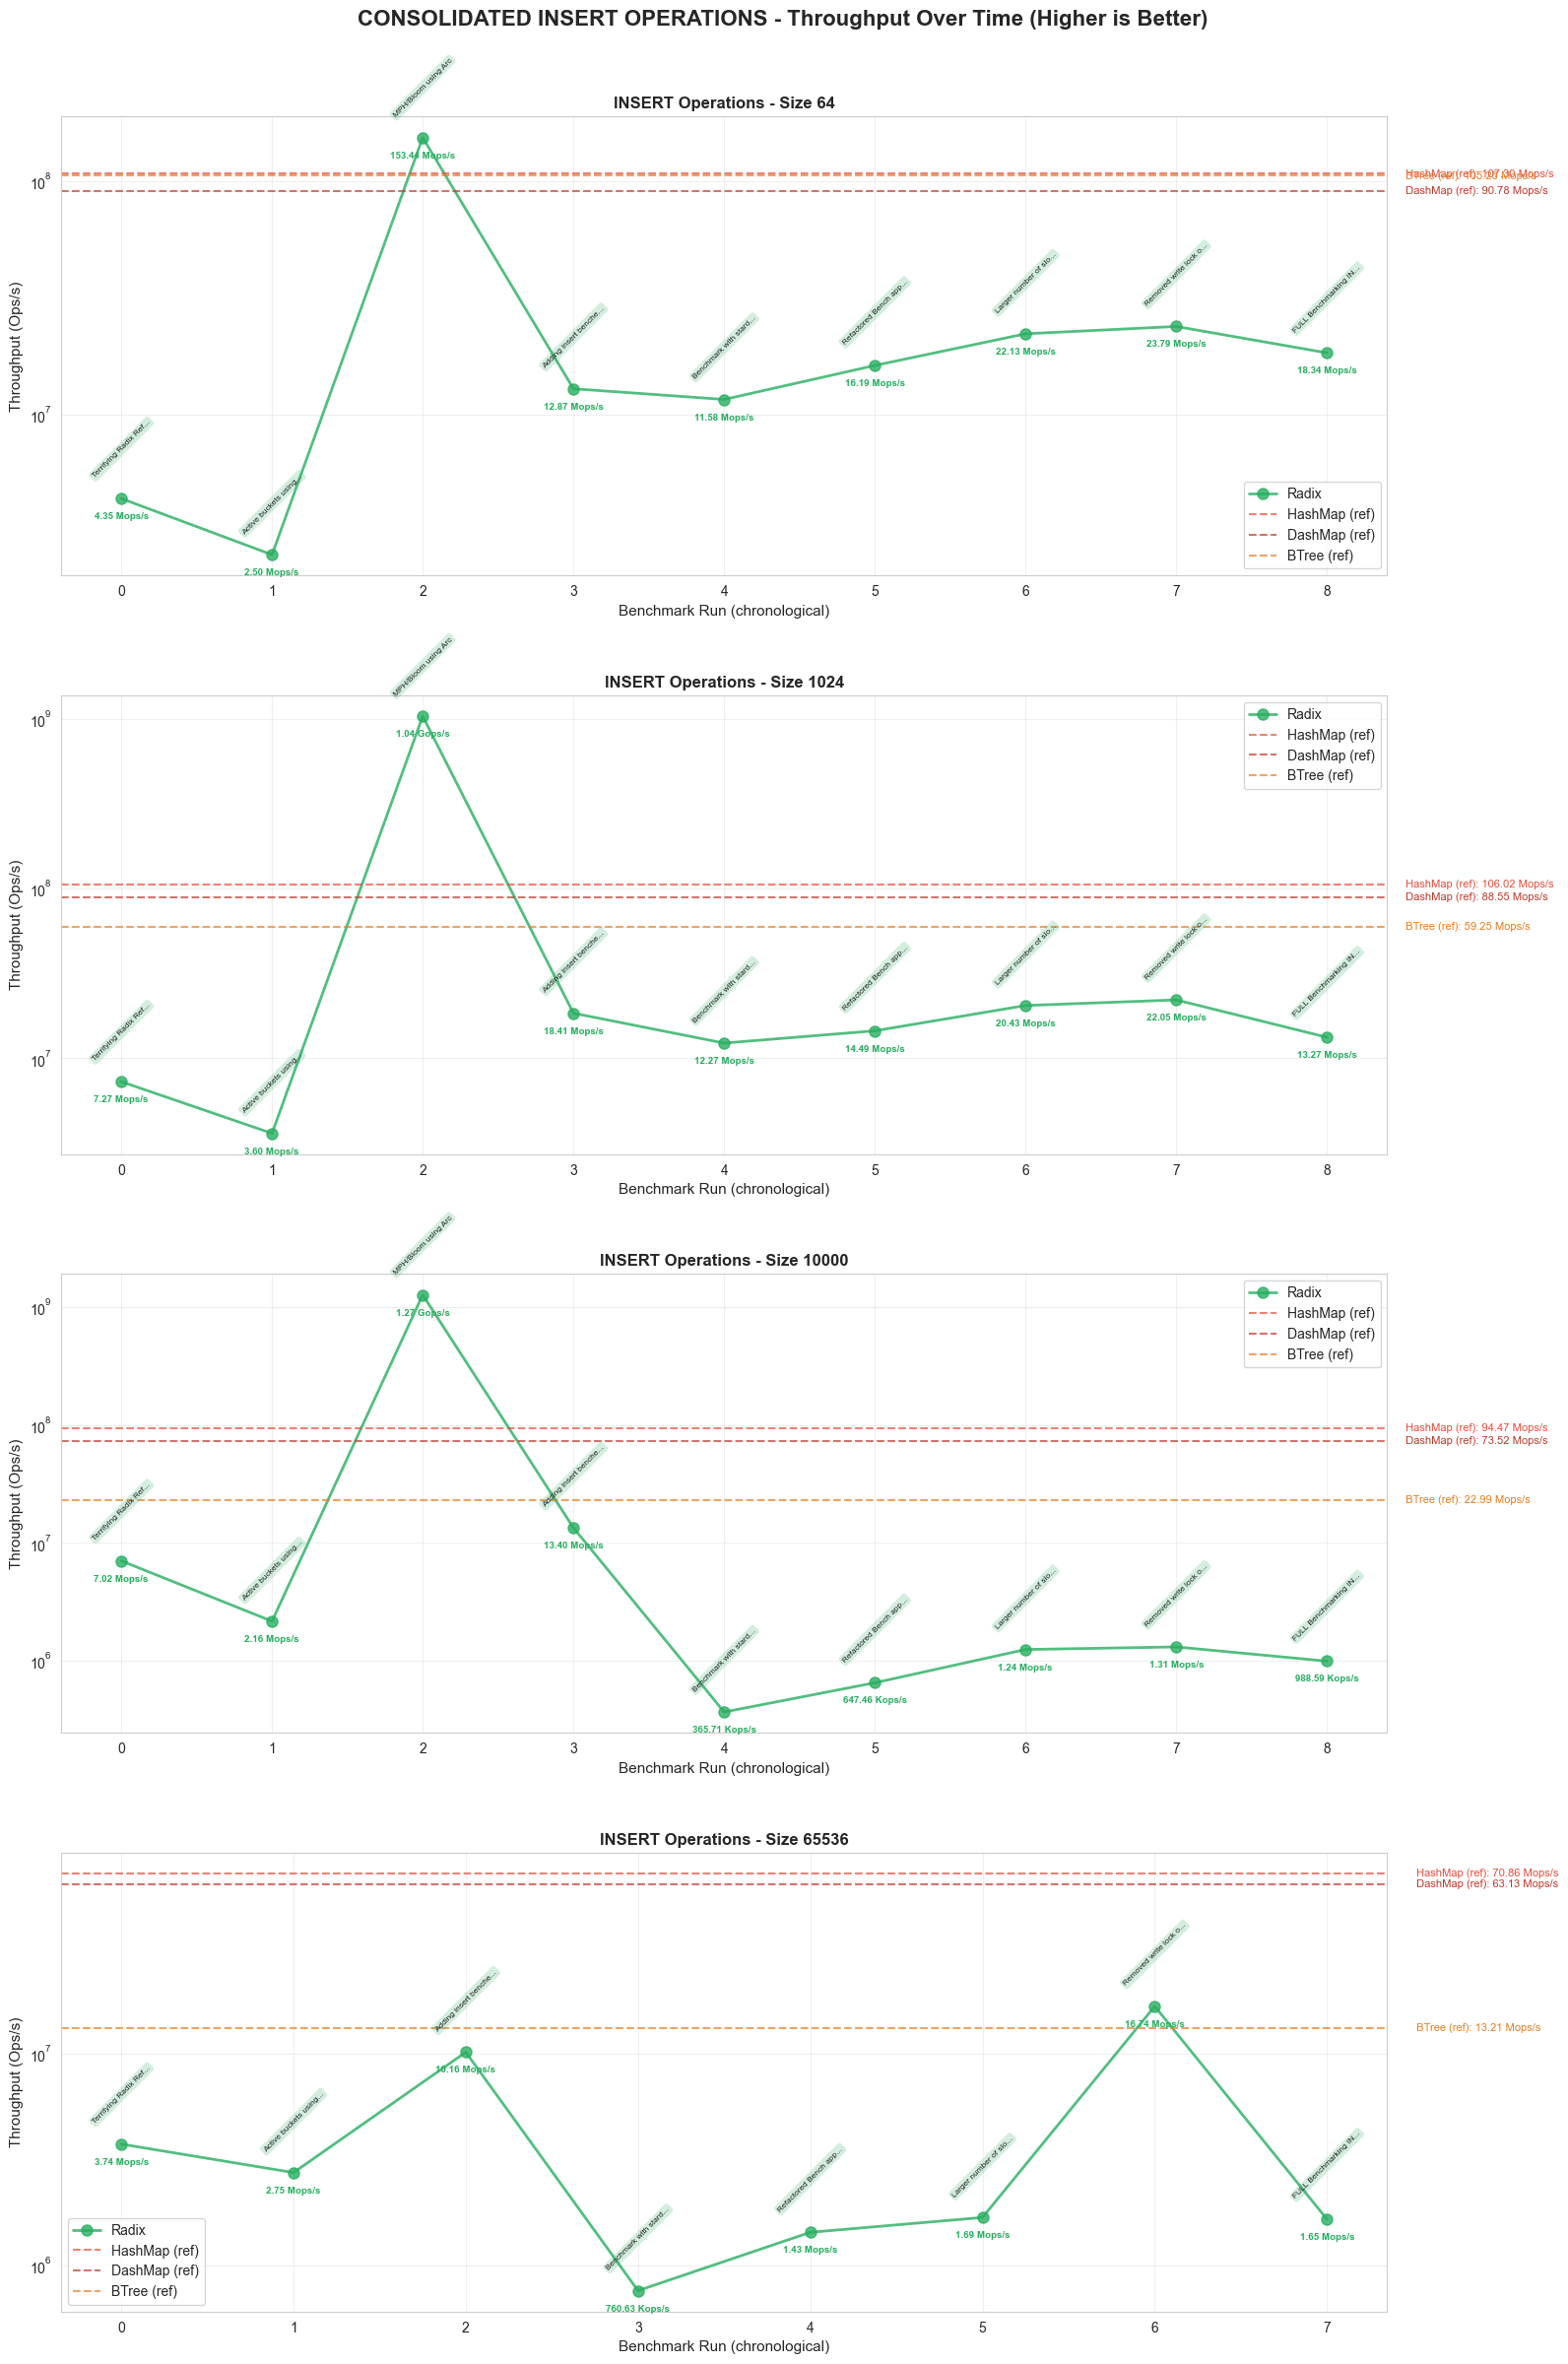

In [40]:
# ============================================================================
# CONSOLIDATED INDEX PERFORMANCE - INSERT OPERATIONS - THROUGHPUT (Higher is Better)
# ============================================================================

# Collect all INSERT data for custom indexes
all_insert_data = pd.concat([
    df_radix_insert_limited,
    df_mph_insert_limited,
    df_standard_mph_insert_limited,
    df_standard_delta_insert_limited
])

# Get unique sizes
insert_sizes = sorted(all_insert_data['size'].unique()) if len(all_insert_data) > 0 else []
num_insert_sizes = len(insert_sizes)

if num_insert_sizes > 0:
    print(f"Creating consolidated INSERT throughput chart for {num_insert_sizes} sizes: {insert_sizes}")
    
    # Create figure
    fig, axes = plt.subplots(num_insert_sizes, 1, figsize=(16, 6 * num_insert_sizes))
    fig.suptitle('CONSOLIDATED INSERT OPERATIONS - Throughput Over Time (Higher is Better)', 
                 fontsize=16, fontweight='bold', y=0.998)
    
    # Ensure axes is iterable even with single size
    if num_insert_sizes == 1:
        axes = [axes]
    
    # Plot each size
    for size_idx, size in enumerate(insert_sizes):
        ax = axes[size_idx]
        
        # Get all data for this size and create unified timeline
        size_data = all_insert_data[all_insert_data['size'] == size].copy()
        unified_timeline = sorted(size_data['timestamp'].unique())
        timestamp_to_index = {ts: idx for idx, ts in enumerate(unified_timeline)}
        
        # Plot each index type
        for operation, config in insert_index_config.items():
            # Filter data for this operation and size
            data = size_data[size_data['operation'] == operation].sort_values('timestamp')
            
            if len(data) > 0:
                # Map timestamps to sequential indices
                x_indices = [timestamp_to_index[ts] for ts in data['timestamp']]
                
                # Plot with sequential indices
                ax.plot(x_indices, data['throughput_ops_sec'], 
                       marker=config['marker'], linewidth=2, markersize=8,
                       color=config['color'], label=config['label'],
                       alpha=0.8)
                
                # Add value and tag labels at each point
                for x_idx, val, pretty, tag in zip(x_indices, data['throughput_ops_sec'], 
                                                    data['throughput_pretty'], data['tag']):
                    # Add value label (closer to point)
                    ax.annotate(pretty, (x_idx, val), 
                               textcoords="offset points", xytext=(0, -15),
                               ha='center', fontsize=7, fontweight='bold',
                               color=config['color'])
                    
                    # Add tag label (further from point)
                    tag_short = tag[:20] + '...' if len(tag) > 20 else tag
                    ax.annotate(tag_short, (x_idx, val), 
                               textcoords="offset points", xytext=(0, 15),
                               ha='center', fontsize=6, rotation=45,
                               bbox=dict(boxstyle='round,pad=0.3', facecolor=config['color'], 
                                        alpha=0.2, edgecolor='none'))
        
        # Add baseline reference lines (latest values only)
        for baseline_op, baseline_cfg in insert_baseline_config.items():
            baseline_data = df_insert_latest[
                (df_insert_latest['operation'] == baseline_op) & 
                (df_insert_latest['size'] == size)
            ]
            if len(baseline_data) > 0:
                baseline_val = baseline_data['throughput_ops_sec'].values[0]
                baseline_pretty = baseline_data['throughput_pretty'].values[0]
                ax.axhline(y=baseline_val, color=baseline_cfg['color'], 
                          linestyle=baseline_cfg['linestyle'], linewidth=1.5,
                          label=baseline_cfg['label'], alpha=0.7)
                # Add label at the right edge
                ax.text(len(unified_timeline) - 0.5, baseline_val, 
                       f" {baseline_cfg['label']}: {baseline_pretty}",
                       va='center', fontsize=8, color=baseline_cfg['color'])
        
        # Customize
        ax.set_xlabel('Benchmark Run (chronological)', fontsize=11)
        ax.set_ylabel('Throughput (Ops/s)', fontsize=11)
        ax.set_title(f'INSERT Operations - Size {size}', fontsize=12, fontweight='bold')
        ax.set_yscale(Y_SCALE)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.set_xticks(range(len(unified_timeline)))
        ax.set_xticklabels([f'{i}' for i in range(len(unified_timeline))], rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("No INSERT data available for custom indexes")
